# Лабораторная работа №2. Реализация глубокой нейронной сети

**Данные:** В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

**Данные можно скачать по ссылке:**
- https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных);
- https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных);

Описание данных на английском языке доступно по ссылке:
- http://yaroslavvb.blogspot.sg/2011/09/notmnist-dataset.html

In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

#### Загружаем данные

In [2]:
import pathlib

train_data_dir = pathlib.Path('./Datasets/1-3/notMNIST_large')

train_image_count = len(list(train_data_dir.glob('*/*.png')))
train_image_count

529114

In [3]:
test_data_dir = pathlib.Path('./Datasets/1-3/notMNIST_small')
test_image_count = len(list(test_data_dir.glob('*/*.png')))
test_image_count

18724

In [4]:
BATCH_SIZE = 1000
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES

array(['H', 'F', 'E', 'I', 'D', 'B', 'A', 'J', 'C', 'G'], dtype='<U1')

In [5]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.02)
train_data_gen = train_image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode='grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 529114 images belonging to 10 classes.


In [6]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = train_image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode='grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 18724 images belonging to 10 classes.


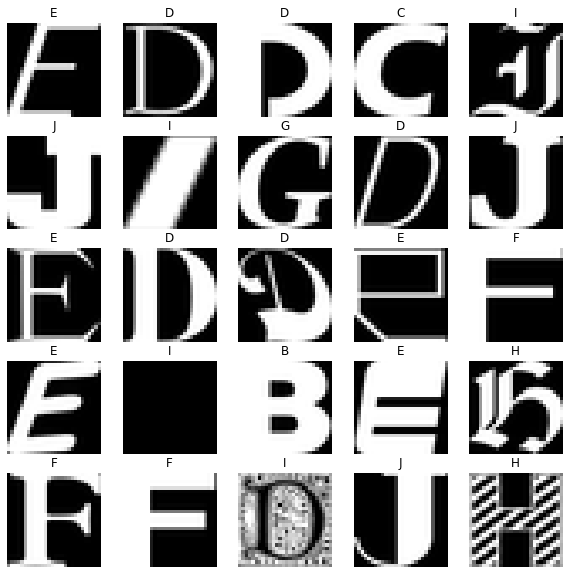

In [7]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n][:, :, 0], cmap='gray')
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

### Задание 1. Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow. В качестве алгоритма оптимизации можно использовать, например, стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).

In [8]:
import random
import datetime

class Model:
    EPOCH_COUNT = 10
    ACTIVATION_FUNCTIONS = (
        'linear',
        'sigmoid', 
        'tanh',
        'relu',
    )
    
    def __init__(self, layers_count, nodes=None, optimizer=None, use_regularizatrion_and_dropuot=False):
        self.use_regularizatrion_and_dropuot = use_regularizatrion_and_dropuot
        self.layers_count = layers_count
        self.inital_nodes = nodes or []
        self._nodes_count = nodes or []
        self.optimizer = optimizer or tf.keras.optimizers.SGD(
            learning_rate=0.1
        )
    
    def _get_layer_nodes_count(self, index):
        if self.inital_nodes:
            return self.inital_nodes[index]

        nodes_count = random.randrange(100, 400)
        self._nodes_count.append(nodes_count)
        return nodes_count
    
    def _generate_layer(self, index):
        nodes_count = self._get_layer_nodes_count(index)
        activation_fun = self.ACTIVATION_FUNCTIONS[index]

        layer = tf.keras.layers.Dense(nodes_count, activation=activation_fun)
        layer._name = f'dense_{index}_{activation_fun}'

        return layer
   
    def _generate_layer_with_regularization(self, index):
        nodes_count = self._get_layer_nodes_count(index)
        activation_fun = self.ACTIVATION_FUNCTIONS[index]
        regularizer = tf.keras.regularizers.l2(0.01)

        layer = tf.keras.layers.Dense(nodes_count, activation=activation_fun, activity_regularizer=regularizer)
        layer._name = f'dense_{index}_{activation_fun}'

        return layer, nodes_count
    
    def _generate_layer_with_regularizatrion_and_dropuot(self, index):
        layer, nodes_count = self._generate_layer_with_regularization(index)
        dropout_rate = np.round(nodes_count / 10000, 2) if nodes_count > 200 else 0
        dropout_layer = tf.keras.layers.Dropout(dropout_rate)
        return [layer, dropout_layer]
    
    def _get_hidden_layers(self):
        if not self.use_regularizatrion_and_dropuot:
            return [self._generate_layer(i) for i in range(self.layers_count)]

        hidden_layers = np.array([
            self._generate_layer_with_regularizatrion_and_dropuot(i)
            for i in range(self.layers_count)
        ])
        return hidden_layers.flatten()

    def initialize(self):
        loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        hidden_layers = self._get_hidden_layers()

        self.model = tf.keras.models.Sequential([
          tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
          *hidden_layers,
          tf.keras.layers.Dense(10, activation='softmax')
        ])

        self.model.compile(optimizer=self.optimizer, loss=loss_fn, metrics=['accuracy'])

    def fit(self, x_train, y_train=None, **kwargs):
        epochs = kwargs.pop('epochs', self.EPOCH_COUNT)
        return self.model.fit(
            x_train,  y_train, workers=6, epochs=epochs, validation_split=0.05, **kwargs)

    def fit_generator(self, generator, batch_count, **kwargs):
        now = datetime.datetime.now()
        tran_accuracy = 0
        val_accuracy = 0

        for i in range(batch_count):
            print(f'Start training batch #{i}')
            x, y = next(generator)
            batch_history = self.fit(x, y, **kwargs)
            tran_accuracy += batch_history.history['accuracy'][-1]
            val_accuracy += batch_history.history['val_accuracy'][-1]
        
        average_train_error = tran_accuracy / batch_count
        average_validation_error = val_accuracy / batch_count

        print('\nSpent time:', datetime.datetime.now() - now)
        print('Average train error:', average_train_error)
        print('Average validation error:', average_validation_error)

        return [average_train_error, average_validation_error]

    def test(self, x_test, y_test=None):
        return self.model.evaluate(x_test,  y_test, verbose=1)
    
    def summary(self):
        return self.model.summary()

In [9]:
model = Model(4)
model.initialize()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_0_linear (Dense)       (None, 329)               258265    
_________________________________________________________________
dense_1_sigmoid (Dense)      (None, 172)               56760     
_________________________________________________________________
dense_2_tanh (Dense)         (None, 128)               22144     
_________________________________________________________________
dense_3_relu (Dense)         (None, 172)               22188     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1730      
Total params: 361,087
Trainable params: 361,087
Non-trainable params: 0
__________________________________________________

### Задание 2. Как улучшилась точность классификатора по сравнению с логистической регрессией?


In [10]:
COUNT_OF_BUTCHES = 210

In [11]:
model.fit_generator(train_data_gen, COUNT_OF_BUTCHES, epochs=20)

Start training batch #0
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 512us/sample - loss: 2.3009 - accuracy: 0.1305 - val_loss: 2.2929 - val_accuracy: 0.1600
Epoch 2/20
950/950 [==============================] - 0s 70us/sample - loss: 2.2895 - accuracy: 0.2326 - val_loss: 2.2795 - val_accuracy: 0.2400
Epoch 3/20
950/950 [==============================] - 0s 77us/sample - loss: 2.2679 - accuracy: 0.2316 - val_loss: 2.2508 - val_accuracy: 0.2600
Epoch 4/20
950/950 [==============================] - 0s 62us/sample - loss: 2.2265 - accuracy: 0.2589 - val_loss: 2.2043 - val_accuracy: 0.2800
Epoch 5/20
950/950 [==============================] - 0s 74us/sample - loss: 2.1808 - accuracy: 0.2874 - val_loss: 2.1601 - val_accuracy: 0.2800
Epoch 6/20
950/950 [==============================] - 0s 73us/sample - loss: 2.1472 - accuracy: 0.3168 - val_loss: 2.1184 - val_accuracy: 0.3600
Epoch 7/20
950/950 [==============================] - 0s 71u

Epoch 16/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6579 - accuracy: 0.8084 - val_loss: 1.6746 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 75us/sample - loss: 1.6579 - accuracy: 0.8084 - val_loss: 1.6705 - val_accuracy: 0.8000
Epoch 18/20
950/950 [==============================] - 0s 73us/sample - loss: 1.6562 - accuracy: 0.8084 - val_loss: 1.6676 - val_accuracy: 0.8000
Epoch 19/20
950/950 [==============================] - 0s 70us/sample - loss: 1.6554 - accuracy: 0.8095 - val_loss: 1.6671 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6539 - accuracy: 0.8105 - val_loss: 1.6736 - val_accuracy: 0.8000
Start training batch #3
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7351 - accuracy: 0.7263 - val_loss: 1.7505 - val_accuracy: 0.7000
Epoch 2/20
950/950 [==============================] - 0s

Epoch 11/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6863 - accuracy: 0.7737 - val_loss: 1.7453 - val_accuracy: 0.7000
Epoch 12/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6849 - accuracy: 0.7758 - val_loss: 1.7372 - val_accuracy: 0.7000
Epoch 13/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6839 - accuracy: 0.7779 - val_loss: 1.7350 - val_accuracy: 0.7000
Epoch 14/20
950/950 [==============================] - 0s 78us/sample - loss: 1.6827 - accuracy: 0.7768 - val_loss: 1.7426 - val_accuracy: 0.7000
Epoch 15/20
950/950 [==============================] - 0s 59us/sample - loss: 1.6793 - accuracy: 0.7821 - val_loss: 1.7372 - val_accuracy: 0.7200
Epoch 16/20
950/950 [==============================] - 0s 60us/sample - loss: 1.6780 - accuracy: 0.7832 - val_loss: 1.7315 - val_accuracy: 0.7200
Epoch 17/20
950/950 [==============================] - 0s 59us/sample - loss: 1.6756 - accuracy: 0.7853 - val_loss: 1.7339 -

Epoch 6/20
950/950 [==============================] - 0s 73us/sample - loss: 1.6861 - accuracy: 0.7768 - val_loss: 1.6493 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 74us/sample - loss: 1.6885 - accuracy: 0.7737 - val_loss: 1.6480 - val_accuracy: 0.8200
Epoch 8/20
950/950 [==============================] - 0s 70us/sample - loss: 1.6880 - accuracy: 0.7747 - val_loss: 1.6431 - val_accuracy: 0.8200
Epoch 9/20
950/950 [==============================] - 0s 73us/sample - loss: 1.6825 - accuracy: 0.7789 - val_loss: 1.6404 - val_accuracy: 0.8200
Epoch 10/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6809 - accuracy: 0.7800 - val_loss: 1.6373 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 73us/sample - loss: 1.6759 - accuracy: 0.7842 - val_loss: 1.6390 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6767 - accuracy: 0.7832 - val_loss: 1.6519 - val

950/950 [==============================] - 0s 71us/sample - loss: 1.7356 - accuracy: 0.7221 - val_loss: 1.6922 - val_accuracy: 0.7800
Epoch 2/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7207 - accuracy: 0.7411 - val_loss: 1.6791 - val_accuracy: 0.7800
Epoch 3/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7088 - accuracy: 0.7516 - val_loss: 1.6833 - val_accuracy: 0.7800
Epoch 4/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7015 - accuracy: 0.7621 - val_loss: 1.6837 - val_accuracy: 0.7800
Epoch 5/20
950/950 [==============================] - 0s 75us/sample - loss: 1.6915 - accuracy: 0.7716 - val_loss: 1.6830 - val_accuracy: 0.7800
Epoch 6/20
950/950 [==============================] - 0s 82us/sample - loss: 1.6858 - accuracy: 0.7737 - val_loss: 1.7047 - val_accuracy: 0.7400
Epoch 7/20
950/950 [==============================] - 0s 74us/sample - loss: 1.6769 - accuracy: 0.7874 - val_loss: 1.6900 - val_accuracy: 0.7

950/950 [==============================] - 0s 83us/sample - loss: 1.6543 - accuracy: 0.8063 - val_loss: 1.7509 - val_accuracy: 0.7200
Epoch 17/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6528 - accuracy: 0.8063 - val_loss: 1.7543 - val_accuracy: 0.7000
Epoch 18/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6524 - accuracy: 0.8074 - val_loss: 1.7532 - val_accuracy: 0.7000
Epoch 19/20
950/950 [==============================] - 0s 83us/sample - loss: 1.6519 - accuracy: 0.8074 - val_loss: 1.7446 - val_accuracy: 0.7000
Epoch 20/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6506 - accuracy: 0.8095 - val_loss: 1.7497 - val_accuracy: 0.7000
Start training batch #14
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7060 - accuracy: 0.7526 - val_loss: 1.6667 - val_accuracy: 0.8000
Epoch 2/20
950/950 [==============================] - 0s 69us/sampl

Epoch 11/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6698 - accuracy: 0.7926 - val_loss: 1.7814 - val_accuracy: 0.6800
Epoch 12/20
950/950 [==============================] - 0s 95us/sample - loss: 1.6675 - accuracy: 0.7926 - val_loss: 1.7726 - val_accuracy: 0.6800
Epoch 13/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6670 - accuracy: 0.7926 - val_loss: 1.7711 - val_accuracy: 0.6800
Epoch 14/20
950/950 [==============================] - 0s 89us/sample - loss: 1.6645 - accuracy: 0.7968 - val_loss: 1.7815 - val_accuracy: 0.6800
Epoch 15/20
950/950 [==============================] - 0s 91us/sample - loss: 1.6637 - accuracy: 0.7968 - val_loss: 1.7675 - val_accuracy: 0.6800
Epoch 16/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6614 - accuracy: 0.7979 - val_loss: 1.7816 - val_accuracy: 0.6800
Epoch 17/20
950/950 [==============================] - 0s 88us/sample - loss: 1.6607 - accuracy: 0.7979 - val_loss: 1.7830 -

Epoch 6/20
950/950 [==============================] - 0s 80us/sample - loss: 1.6713 - accuracy: 0.7916 - val_loss: 1.6242 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6687 - accuracy: 0.7916 - val_loss: 1.6209 - val_accuracy: 0.8600
Epoch 8/20
950/950 [==============================] - 0s 80us/sample - loss: 1.6670 - accuracy: 0.7916 - val_loss: 1.6209 - val_accuracy: 0.8600
Epoch 9/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6656 - accuracy: 0.7937 - val_loss: 1.6156 - val_accuracy: 0.8600
Epoch 10/20
950/950 [==============================] - 0s 96us/sample - loss: 1.6647 - accuracy: 0.7947 - val_loss: 1.6301 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6636 - accuracy: 0.7958 - val_loss: 1.6323 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 82us/sample - loss: 1.6630 - accuracy: 0.7968 - val_loss: 1.6222 - val

950/950 [==============================] - 0s 91us/sample - loss: 1.6157 - accuracy: 0.8442 - val_loss: 1.5703 - val_accuracy: 0.9000
Epoch 2/20
950/950 [==============================] - 0s 85us/sample - loss: 1.6041 - accuracy: 0.8579 - val_loss: 1.5756 - val_accuracy: 0.8800
Epoch 3/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5951 - accuracy: 0.8684 - val_loss: 1.5730 - val_accuracy: 0.8800
Epoch 4/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5868 - accuracy: 0.8758 - val_loss: 1.5681 - val_accuracy: 0.9000
Epoch 5/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5801 - accuracy: 0.8832 - val_loss: 1.5713 - val_accuracy: 0.8800
Epoch 6/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5804 - accuracy: 0.8874 - val_loss: 1.5670 - val_accuracy: 0.9000
Epoch 7/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5723 - accuracy: 0.8895 - val_loss: 1.5805 - val_accuracy: 0.8

950/950 [==============================] - 0s 80us/sample - loss: 1.5855 - accuracy: 0.8768 - val_loss: 1.5791 - val_accuracy: 0.8800
Epoch 17/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5856 - accuracy: 0.8768 - val_loss: 1.5748 - val_accuracy: 0.8800
Epoch 18/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5820 - accuracy: 0.8800 - val_loss: 1.5804 - val_accuracy: 0.8800
Epoch 19/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5811 - accuracy: 0.8811 - val_loss: 1.5903 - val_accuracy: 0.8800
Epoch 20/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5785 - accuracy: 0.8842 - val_loss: 1.5845 - val_accuracy: 0.8800
Start training batch #25
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 68us/sample - loss: 1.6349 - accuracy: 0.8274 - val_loss: 1.7154 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 62us/sampl

Epoch 11/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5873 - accuracy: 0.8737 - val_loss: 1.6482 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5866 - accuracy: 0.8737 - val_loss: 1.6576 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5866 - accuracy: 0.8747 - val_loss: 1.6558 - val_accuracy: 0.8000
Epoch 14/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5834 - accuracy: 0.8789 - val_loss: 1.6663 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5812 - accuracy: 0.8800 - val_loss: 1.6603 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5808 - accuracy: 0.8800 - val_loss: 1.6596 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5802 - accuracy: 0.8800 - val_loss: 1.6575 -

Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5901 - accuracy: 0.8705 - val_loss: 1.6716 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 88us/sample - loss: 1.5839 - accuracy: 0.8779 - val_loss: 1.6659 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5819 - accuracy: 0.8800 - val_loss: 1.6751 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5824 - accuracy: 0.8789 - val_loss: 1.6739 - val_accuracy: 0.7800
Epoch 10/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5798 - accuracy: 0.8821 - val_loss: 1.6749 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5788 - accuracy: 0.8821 - val_loss: 1.6767 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5784 - accuracy: 0.8821 - val_loss: 1.6759 - val

950/950 [==============================] - 0s 75us/sample - loss: 1.6298 - accuracy: 0.8274 - val_loss: 1.5902 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6121 - accuracy: 0.8484 - val_loss: 1.5793 - val_accuracy: 0.8800
Epoch 3/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6031 - accuracy: 0.8558 - val_loss: 1.5715 - val_accuracy: 0.8800
Epoch 4/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5951 - accuracy: 0.8653 - val_loss: 1.5640 - val_accuracy: 0.9000
Epoch 5/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5905 - accuracy: 0.8695 - val_loss: 1.5698 - val_accuracy: 0.9000
Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5839 - accuracy: 0.8789 - val_loss: 1.5640 - val_accuracy: 0.9000
Epoch 7/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5840 - accuracy: 0.8789 - val_loss: 1.5753 - val_accuracy: 0.8

950/950 [==============================] - 0s 67us/sample - loss: 1.5850 - accuracy: 0.8758 - val_loss: 1.6309 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5847 - accuracy: 0.8758 - val_loss: 1.6263 - val_accuracy: 0.8200
Epoch 18/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5846 - accuracy: 0.8758 - val_loss: 1.6240 - val_accuracy: 0.8200
Epoch 19/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5845 - accuracy: 0.8758 - val_loss: 1.6247 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5845 - accuracy: 0.8758 - val_loss: 1.6239 - val_accuracy: 0.8200
Start training batch #36
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 61us/sample - loss: 1.6262 - accuracy: 0.8358 - val_loss: 1.7050 - val_accuracy: 0.7400
Epoch 2/20
950/950 [==============================] - 0s 55us/sampl

Epoch 11/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5676 - accuracy: 0.8937 - val_loss: 1.6417 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5659 - accuracy: 0.8947 - val_loss: 1.6407 - val_accuracy: 0.8200
Epoch 13/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5647 - accuracy: 0.8968 - val_loss: 1.6390 - val_accuracy: 0.8200
Epoch 14/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5658 - accuracy: 0.8947 - val_loss: 1.6579 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5628 - accuracy: 0.8979 - val_loss: 1.6371 - val_accuracy: 0.8200
Epoch 16/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5628 - accuracy: 0.8979 - val_loss: 1.6553 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5619 - accuracy: 0.9011 - val_loss: 1.6564 -

Epoch 6/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5876 - accuracy: 0.8758 - val_loss: 1.6422 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5890 - accuracy: 0.8716 - val_loss: 1.6767 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5827 - accuracy: 0.8789 - val_loss: 1.6549 - val_accuracy: 0.8200
Epoch 9/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5823 - accuracy: 0.8789 - val_loss: 1.6720 - val_accuracy: 0.7800
Epoch 10/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5826 - accuracy: 0.8779 - val_loss: 1.6720 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 109us/sample - loss: 1.5814 - accuracy: 0.8789 - val_loss: 1.6711 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5822 - accuracy: 0.8779 - val_loss: 1.6745 - va

950/950 [==============================] - 0s 62us/sample - loss: 1.6320 - accuracy: 0.8263 - val_loss: 1.6745 - val_accuracy: 0.7800
Epoch 2/20
950/950 [==============================] - 0s 61us/sample - loss: 1.6134 - accuracy: 0.8484 - val_loss: 1.6922 - val_accuracy: 0.7800
Epoch 3/20
950/950 [==============================] - 0s 72us/sample - loss: 1.6049 - accuracy: 0.8558 - val_loss: 1.6808 - val_accuracy: 0.7800
Epoch 4/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5994 - accuracy: 0.8632 - val_loss: 1.6740 - val_accuracy: 0.7800
Epoch 5/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5939 - accuracy: 0.8684 - val_loss: 1.6809 - val_accuracy: 0.7800
Epoch 6/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5921 - accuracy: 0.8684 - val_loss: 1.6714 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5872 - accuracy: 0.8737 - val_loss: 1.6756 - val_accuracy: 0.7

950/950 [==============================] - 0s 72us/sample - loss: 1.5787 - accuracy: 0.8821 - val_loss: 1.6255 - val_accuracy: 0.8400
Epoch 17/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5785 - accuracy: 0.8821 - val_loss: 1.6258 - val_accuracy: 0.8400
Epoch 18/20
950/950 [==============================] - 0s 65us/sample - loss: 1.5784 - accuracy: 0.8821 - val_loss: 1.6237 - val_accuracy: 0.8400
Epoch 19/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5783 - accuracy: 0.8821 - val_loss: 1.6227 - val_accuracy: 0.8400
Epoch 20/20
950/950 [==============================] - 0s 88us/sample - loss: 1.5779 - accuracy: 0.8832 - val_loss: 1.6238 - val_accuracy: 0.8400
Start training batch #47
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 75us/sample - loss: 1.6322 - accuracy: 0.8274 - val_loss: 1.7420 - val_accuracy: 0.7400
Epoch 2/20
950/950 [==============================] - 0s 68us/sampl

Epoch 11/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5826 - accuracy: 0.8779 - val_loss: 1.5880 - val_accuracy: 0.8800
Epoch 12/20
950/950 [==============================] - 0s 65us/sample - loss: 1.5823 - accuracy: 0.8779 - val_loss: 1.5879 - val_accuracy: 0.8800
Epoch 13/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5816 - accuracy: 0.8800 - val_loss: 1.5871 - val_accuracy: 0.8800
Epoch 14/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5805 - accuracy: 0.8800 - val_loss: 1.5882 - val_accuracy: 0.8800
Epoch 15/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5790 - accuracy: 0.8811 - val_loss: 1.5893 - val_accuracy: 0.8800
Epoch 16/20
950/950 [==============================] - 0s 65us/sample - loss: 1.5784 - accuracy: 0.8811 - val_loss: 1.5888 - val_accuracy: 0.8800
Epoch 17/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5773 - accuracy: 0.8832 - val_loss: 1.5899 -

Epoch 6/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5908 - accuracy: 0.8695 - val_loss: 1.6489 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5889 - accuracy: 0.8726 - val_loss: 1.6466 - val_accuracy: 0.8200
Epoch 8/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5868 - accuracy: 0.8726 - val_loss: 1.6398 - val_accuracy: 0.8200
Epoch 9/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5810 - accuracy: 0.8811 - val_loss: 1.6421 - val_accuracy: 0.8200
Epoch 10/20
950/950 [==============================] - 0s 112us/sample - loss: 1.5814 - accuracy: 0.8789 - val_loss: 1.6397 - val_accuracy: 0.8200
Epoch 11/20
950/950 [==============================] - 0s 95us/sample - loss: 1.5784 - accuracy: 0.8832 - val_loss: 1.6434 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 106us/sample - loss: 1.5770 - accuracy: 0.8842 - val_loss: 1.6395 - v

950/950 [==============================] - 0s 65us/sample - loss: 1.6235 - accuracy: 0.8358 - val_loss: 1.5956 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0s 62us/sample - loss: 1.6140 - accuracy: 0.8463 - val_loss: 1.6135 - val_accuracy: 0.8400
Epoch 3/20
950/950 [==============================] - 0s 68us/sample - loss: 1.6066 - accuracy: 0.8537 - val_loss: 1.5706 - val_accuracy: 0.9000
Epoch 4/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5989 - accuracy: 0.8632 - val_loss: 1.5890 - val_accuracy: 0.8800
Epoch 5/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5901 - accuracy: 0.8705 - val_loss: 1.5820 - val_accuracy: 0.8800
Epoch 6/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5860 - accuracy: 0.8789 - val_loss: 1.5881 - val_accuracy: 0.8800
Epoch 7/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5818 - accuracy: 0.8811 - val_loss: 1.5711 - val_accuracy: 0.9

950/950 [==============================] - 0s 67us/sample - loss: 1.5574 - accuracy: 0.9032 - val_loss: 1.6243 - val_accuracy: 0.8400
Epoch 17/20
950/950 [==============================] - 0s 61us/sample - loss: 1.5572 - accuracy: 0.9032 - val_loss: 1.6238 - val_accuracy: 0.8400
Epoch 18/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5569 - accuracy: 0.9042 - val_loss: 1.6230 - val_accuracy: 0.8400
Epoch 19/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5562 - accuracy: 0.9042 - val_loss: 1.6231 - val_accuracy: 0.8400
Epoch 20/20
950/950 [==============================] - 0s 60us/sample - loss: 1.5561 - accuracy: 0.9042 - val_loss: 1.6230 - val_accuracy: 0.8400
Start training batch #58
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 59us/sample - loss: 1.6212 - accuracy: 0.8400 - val_loss: 1.5946 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 62us/sampl

Epoch 11/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5813 - accuracy: 0.8789 - val_loss: 1.6431 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5779 - accuracy: 0.8842 - val_loss: 1.6483 - val_accuracy: 0.8200
Epoch 13/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5759 - accuracy: 0.8853 - val_loss: 1.6396 - val_accuracy: 0.8200
Epoch 14/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5753 - accuracy: 0.8853 - val_loss: 1.6393 - val_accuracy: 0.8200
Epoch 15/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5751 - accuracy: 0.8853 - val_loss: 1.6403 - val_accuracy: 0.8200
Epoch 16/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5751 - accuracy: 0.8863 - val_loss: 1.6394 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5741 - accuracy: 0.8863 - val_loss: 1.6399 -

Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5921 - accuracy: 0.8716 - val_loss: 1.6747 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5852 - accuracy: 0.8747 - val_loss: 1.6774 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5824 - accuracy: 0.8789 - val_loss: 1.6860 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5829 - accuracy: 0.8811 - val_loss: 1.6899 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5797 - accuracy: 0.8811 - val_loss: 1.6865 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5772 - accuracy: 0.8842 - val_loss: 1.6796 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5773 - accuracy: 0.8842 - val_loss: 1.6729 - val

950/950 [==============================] - 0s 65us/sample - loss: 1.6434 - accuracy: 0.8158 - val_loss: 1.7013 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 70us/sample - loss: 1.6339 - accuracy: 0.8263 - val_loss: 1.7013 - val_accuracy: 0.7600
Epoch 3/20
950/950 [==============================] - 0s 78us/sample - loss: 1.6286 - accuracy: 0.8305 - val_loss: 1.7074 - val_accuracy: 0.7600
Epoch 4/20
950/950 [==============================] - 0s 85us/sample - loss: 1.6202 - accuracy: 0.8411 - val_loss: 1.7062 - val_accuracy: 0.7600
Epoch 5/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6135 - accuracy: 0.8463 - val_loss: 1.7089 - val_accuracy: 0.7400
Epoch 6/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6077 - accuracy: 0.8537 - val_loss: 1.7072 - val_accuracy: 0.7600
Epoch 7/20
950/950 [==============================] - 0s 74us/sample - loss: 1.6087 - accuracy: 0.8526 - val_loss: 1.7200 - val_accuracy: 0.7

950/950 [==============================] - 0s 96us/sample - loss: 1.5675 - accuracy: 0.8926 - val_loss: 1.5210 - val_accuracy: 0.9400
Epoch 17/20
950/950 [==============================] - 0s 101us/sample - loss: 1.5674 - accuracy: 0.8926 - val_loss: 1.5207 - val_accuracy: 0.9400
Epoch 18/20
950/950 [==============================] - 0s 98us/sample - loss: 1.5674 - accuracy: 0.8926 - val_loss: 1.5209 - val_accuracy: 0.9400
Epoch 19/20
950/950 [==============================] - 0s 96us/sample - loss: 1.5673 - accuracy: 0.8926 - val_loss: 1.5205 - val_accuracy: 0.9400
Epoch 20/20
950/950 [==============================] - 0s 98us/sample - loss: 1.5673 - accuracy: 0.8926 - val_loss: 1.5205 - val_accuracy: 0.9400
Start training batch #69
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 64us/sample - loss: 1.6275 - accuracy: 0.8295 - val_loss: 1.6068 - val_accuracy: 0.8400
Epoch 2/20
950/950 [==============================] - 0s 73us/samp

Epoch 11/20
950/950 [==============================] - 0s 99us/sample - loss: 1.6006 - accuracy: 0.8600 - val_loss: 1.6530 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 101us/sample - loss: 1.6002 - accuracy: 0.8600 - val_loss: 1.6563 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 95us/sample - loss: 1.6000 - accuracy: 0.8600 - val_loss: 1.6594 - val_accuracy: 0.8000
Epoch 14/20
950/950 [==============================] - 0s 92us/sample - loss: 1.5990 - accuracy: 0.8611 - val_loss: 1.6532 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 102us/sample - loss: 1.5984 - accuracy: 0.8621 - val_loss: 1.6484 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 104us/sample - loss: 1.5981 - accuracy: 0.8621 - val_loss: 1.6505 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 98us/sample - loss: 1.5979 - accuracy: 0.8621 - val_loss: 1.651

Epoch 6/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5768 - accuracy: 0.8853 - val_loss: 1.6807 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5733 - accuracy: 0.8884 - val_loss: 1.6809 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5703 - accuracy: 0.8905 - val_loss: 1.6829 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5690 - accuracy: 0.8916 - val_loss: 1.6838 - val_accuracy: 0.7800
Epoch 10/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5687 - accuracy: 0.8916 - val_loss: 1.6838 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5685 - accuracy: 0.8916 - val_loss: 1.6825 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5679 - accuracy: 0.8926 - val_loss: 1.6829 - val

Start training batch #77
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 62us/sample - loss: 1.6255 - accuracy: 0.8347 - val_loss: 1.5806 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0s 67us/sample - loss: 1.6174 - accuracy: 0.8442 - val_loss: 1.5684 - val_accuracy: 0.9000
Epoch 3/20
950/950 [==============================] - 0s 68us/sample - loss: 1.6060 - accuracy: 0.8547 - val_loss: 1.5782 - val_accuracy: 0.8800
Epoch 4/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5952 - accuracy: 0.8684 - val_loss: 1.5858 - val_accuracy: 0.8800
Epoch 5/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5944 - accuracy: 0.8674 - val_loss: 1.5677 - val_accuracy: 0.8800
Epoch 6/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5927 - accuracy: 0.8695 - val_loss: 1.5803 - val_accuracy: 0.8800
Epoch 7/20
950/950 [==============================] - 0s 69u

Epoch 16/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5825 - accuracy: 0.8768 - val_loss: 1.5877 - val_accuracy: 0.8800
Epoch 17/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5815 - accuracy: 0.8779 - val_loss: 1.5930 - val_accuracy: 0.8800
Epoch 18/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5810 - accuracy: 0.8789 - val_loss: 1.5868 - val_accuracy: 0.8800
Epoch 19/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5801 - accuracy: 0.8800 - val_loss: 1.5918 - val_accuracy: 0.8800
Epoch 20/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5798 - accuracy: 0.8800 - val_loss: 1.5904 - val_accuracy: 0.8800
Start training batch #80
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 72us/sample - loss: 1.6145 - accuracy: 0.8453 - val_loss: 1.5813 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0

Epoch 11/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5696 - accuracy: 0.8916 - val_loss: 1.5970 - val_accuracy: 0.8800
Epoch 12/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5663 - accuracy: 0.8947 - val_loss: 1.6003 - val_accuracy: 0.8600
Epoch 13/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5659 - accuracy: 0.8947 - val_loss: 1.6015 - val_accuracy: 0.8600
Epoch 14/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5658 - accuracy: 0.8947 - val_loss: 1.6053 - val_accuracy: 0.8400
Epoch 15/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5657 - accuracy: 0.8947 - val_loss: 1.6060 - val_accuracy: 0.8400
Epoch 16/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5655 - accuracy: 0.8947 - val_loss: 1.6149 - val_accuracy: 0.8400
Epoch 17/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5648 - accuracy: 0.8958 - val_loss: 1.6141 -

Epoch 6/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5838 - accuracy: 0.8789 - val_loss: 1.7042 - val_accuracy: 0.7600
Epoch 7/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5816 - accuracy: 0.8811 - val_loss: 1.7076 - val_accuracy: 0.7600
Epoch 8/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5790 - accuracy: 0.8821 - val_loss: 1.7111 - val_accuracy: 0.7400
Epoch 9/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5777 - accuracy: 0.8832 - val_loss: 1.7061 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5763 - accuracy: 0.8842 - val_loss: 1.7067 - val_accuracy: 0.7600
Epoch 11/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5753 - accuracy: 0.8853 - val_loss: 1.7066 - val_accuracy: 0.7600
Epoch 12/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5751 - accuracy: 0.8853 - val_loss: 1.7060 - val

950/950 [==============================] - 0s 73us/sample - loss: 1.6107 - accuracy: 0.8495 - val_loss: 1.5456 - val_accuracy: 0.9000
Epoch 2/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5994 - accuracy: 0.8589 - val_loss: 1.5541 - val_accuracy: 0.9000
Epoch 3/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5893 - accuracy: 0.8726 - val_loss: 1.5486 - val_accuracy: 0.9200
Epoch 4/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5869 - accuracy: 0.8726 - val_loss: 1.5626 - val_accuracy: 0.9000
Epoch 5/20
950/950 [==============================] - 0s 62us/sample - loss: 1.5762 - accuracy: 0.8853 - val_loss: 1.5555 - val_accuracy: 0.9000
Epoch 6/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5770 - accuracy: 0.8832 - val_loss: 1.5598 - val_accuracy: 0.9000
Epoch 7/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5663 - accuracy: 0.8958 - val_loss: 1.5427 - val_accuracy: 0.9

950/950 [==============================] - 0s 74us/sample - loss: 1.5506 - accuracy: 0.9095 - val_loss: 1.5588 - val_accuracy: 0.9000
Epoch 17/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5505 - accuracy: 0.9095 - val_loss: 1.5586 - val_accuracy: 0.9000
Epoch 18/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5499 - accuracy: 0.9105 - val_loss: 1.5595 - val_accuracy: 0.9000
Epoch 19/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5496 - accuracy: 0.9105 - val_loss: 1.5597 - val_accuracy: 0.9000
Epoch 20/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5495 - accuracy: 0.9105 - val_loss: 1.5590 - val_accuracy: 0.9000
Start training batch #91
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 67us/sample - loss: 1.6157 - accuracy: 0.8463 - val_loss: 1.6024 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 63us/sampl

Epoch 11/20
950/950 [==============================] - 0s 85us/sample - loss: 1.5671 - accuracy: 0.8926 - val_loss: 1.6160 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5648 - accuracy: 0.8958 - val_loss: 1.6164 - val_accuracy: 0.8600
Epoch 13/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5633 - accuracy: 0.8979 - val_loss: 1.6201 - val_accuracy: 0.8400
Epoch 14/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5632 - accuracy: 0.8968 - val_loss: 1.6264 - val_accuracy: 0.8400
Epoch 15/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5621 - accuracy: 0.8989 - val_loss: 1.6232 - val_accuracy: 0.8400
Epoch 16/20
950/950 [==============================] - 0s 90us/sample - loss: 1.5616 - accuracy: 0.8989 - val_loss: 1.6207 - val_accuracy: 0.8400
Epoch 17/20
950/950 [==============================] - 0s 93us/sample - loss: 1.5614 - accuracy: 0.8989 - val_loss: 1.6201 -

Epoch 6/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5953 - accuracy: 0.8674 - val_loss: 1.5901 - val_accuracy: 0.8800
Epoch 7/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5888 - accuracy: 0.8726 - val_loss: 1.5673 - val_accuracy: 0.9000
Epoch 8/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5880 - accuracy: 0.8737 - val_loss: 1.5790 - val_accuracy: 0.9000
Epoch 9/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5849 - accuracy: 0.8737 - val_loss: 1.5773 - val_accuracy: 0.8800
Epoch 10/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5792 - accuracy: 0.8821 - val_loss: 1.5800 - val_accuracy: 0.8800
Epoch 11/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5757 - accuracy: 0.8863 - val_loss: 1.5829 - val_accuracy: 0.8800
Epoch 12/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5740 - accuracy: 0.8874 - val_loss: 1.5817 - val

950/950 [==============================] - 0s 63us/sample - loss: 1.6228 - accuracy: 0.8368 - val_loss: 1.5631 - val_accuracy: 0.9000
Epoch 2/20
950/950 [==============================] - 0s 58us/sample - loss: 1.6102 - accuracy: 0.8516 - val_loss: 1.5431 - val_accuracy: 0.9200
Epoch 3/20
950/950 [==============================] - 0s 55us/sample - loss: 1.6095 - accuracy: 0.8516 - val_loss: 1.5585 - val_accuracy: 0.9000
Epoch 4/20
950/950 [==============================] - 0s 59us/sample - loss: 1.5959 - accuracy: 0.8663 - val_loss: 1.5585 - val_accuracy: 0.9000
Epoch 5/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5924 - accuracy: 0.8684 - val_loss: 1.5472 - val_accuracy: 0.9200
Epoch 6/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5894 - accuracy: 0.8737 - val_loss: 1.5436 - val_accuracy: 0.9200
Epoch 7/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5859 - accuracy: 0.8747 - val_loss: 1.5443 - val_accuracy: 0.9

950/950 [==============================] - 0s 106us/sample - loss: 1.5674 - accuracy: 0.8926 - val_loss: 1.5382 - val_accuracy: 0.9200
Epoch 17/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5674 - accuracy: 0.8926 - val_loss: 1.5381 - val_accuracy: 0.9200
Epoch 18/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5673 - accuracy: 0.8926 - val_loss: 1.5376 - val_accuracy: 0.9200
Epoch 19/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5673 - accuracy: 0.8926 - val_loss: 1.5382 - val_accuracy: 0.9200
Epoch 20/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5672 - accuracy: 0.8926 - val_loss: 1.5361 - val_accuracy: 0.9200
Start training batch #102
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 74us/sample - loss: 1.6269 - accuracy: 0.8358 - val_loss: 1.5910 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0s 76us/sam

Epoch 11/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5809 - accuracy: 0.8800 - val_loss: 1.6426 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5791 - accuracy: 0.8811 - val_loss: 1.6389 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5791 - accuracy: 0.8832 - val_loss: 1.6333 - val_accuracy: 0.8000
Epoch 14/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5764 - accuracy: 0.8842 - val_loss: 1.6431 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5762 - accuracy: 0.8842 - val_loss: 1.6431 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5758 - accuracy: 0.8842 - val_loss: 1.6435 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5749 - accuracy: 0.8853 - val_loss: 1.6405 -

Epoch 6/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5901 - accuracy: 0.8716 - val_loss: 1.5464 - val_accuracy: 0.9200
Epoch 7/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5946 - accuracy: 0.8674 - val_loss: 1.5523 - val_accuracy: 0.9000
Epoch 8/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5940 - accuracy: 0.8663 - val_loss: 1.5412 - val_accuracy: 0.9200
Epoch 9/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5886 - accuracy: 0.8737 - val_loss: 1.5420 - val_accuracy: 0.9200
Epoch 10/20
950/950 [==============================] - 0s 65us/sample - loss: 1.5860 - accuracy: 0.8747 - val_loss: 1.5439 - val_accuracy: 0.9200
Epoch 11/20
950/950 [==============================] - 0s 58us/sample - loss: 1.5824 - accuracy: 0.8789 - val_loss: 1.5417 - val_accuracy: 0.9200
Epoch 12/20
950/950 [==============================] - 0s 61us/sample - loss: 1.5810 - accuracy: 0.8800 - val_loss: 1.5434 - val

950/950 [==============================] - 0s 76us/sample - loss: 1.6234 - accuracy: 0.8358 - val_loss: 1.5450 - val_accuracy: 0.9200
Epoch 2/20
950/950 [==============================] - 0s 85us/sample - loss: 1.6174 - accuracy: 0.8421 - val_loss: 1.5433 - val_accuracy: 0.9200
Epoch 3/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6059 - accuracy: 0.8547 - val_loss: 1.5504 - val_accuracy: 0.9200
Epoch 4/20
950/950 [==============================] - 0s 90us/sample - loss: 1.6010 - accuracy: 0.8600 - val_loss: 1.5437 - val_accuracy: 0.9200
Epoch 5/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5940 - accuracy: 0.8684 - val_loss: 1.5655 - val_accuracy: 0.8800
Epoch 6/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5881 - accuracy: 0.8726 - val_loss: 1.5633 - val_accuracy: 0.9000
Epoch 7/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5858 - accuracy: 0.8768 - val_loss: 1.5508 - val_accuracy: 0.9

950/950 [==============================] - 0s 86us/sample - loss: 1.5709 - accuracy: 0.8895 - val_loss: 1.6696 - val_accuracy: 0.7800
Epoch 17/20
950/950 [==============================] - 0s 85us/sample - loss: 1.5706 - accuracy: 0.8895 - val_loss: 1.6708 - val_accuracy: 0.7800
Epoch 18/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5701 - accuracy: 0.8905 - val_loss: 1.6750 - val_accuracy: 0.7800
Epoch 19/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5702 - accuracy: 0.8895 - val_loss: 1.6705 - val_accuracy: 0.7800
Epoch 20/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5696 - accuracy: 0.8905 - val_loss: 1.6724 - val_accuracy: 0.7800
Start training batch #113
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 64us/sample - loss: 1.6197 - accuracy: 0.8453 - val_loss: 1.5799 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0s 61us/samp

Epoch 11/20
950/950 [==============================] - 0s 63us/sample - loss: 1.6081 - accuracy: 0.8516 - val_loss: 1.6026 - val_accuracy: 0.8600
Epoch 12/20
950/950 [==============================] - 0s 81us/sample - loss: 1.6073 - accuracy: 0.8526 - val_loss: 1.6008 - val_accuracy: 0.8600
Epoch 13/20
950/950 [==============================] - 0s 82us/sample - loss: 1.6071 - accuracy: 0.8526 - val_loss: 1.5999 - val_accuracy: 0.8600
Epoch 14/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6071 - accuracy: 0.8526 - val_loss: 1.5999 - val_accuracy: 0.8600
Epoch 15/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6070 - accuracy: 0.8526 - val_loss: 1.5998 - val_accuracy: 0.8600
Epoch 16/20
950/950 [==============================] - 0s 82us/sample - loss: 1.6070 - accuracy: 0.8526 - val_loss: 1.5997 - val_accuracy: 0.8600
Epoch 17/20
950/950 [==============================] - 0s 84us/sample - loss: 1.6069 - accuracy: 0.8526 - val_loss: 1.5994 -

Epoch 6/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5864 - accuracy: 0.8758 - val_loss: 1.6010 - val_accuracy: 0.8600
Epoch 7/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5850 - accuracy: 0.8758 - val_loss: 1.6013 - val_accuracy: 0.8600
Epoch 8/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5846 - accuracy: 0.8758 - val_loss: 1.6013 - val_accuracy: 0.8600
Epoch 9/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5841 - accuracy: 0.8758 - val_loss: 1.6158 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5855 - accuracy: 0.8758 - val_loss: 1.6009 - val_accuracy: 0.8600
Epoch 11/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5834 - accuracy: 0.8768 - val_loss: 1.6010 - val_accuracy: 0.8600
Epoch 12/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5829 - accuracy: 0.8779 - val_loss: 1.6010 - val

950/950 [==============================] - 0s 63us/sample - loss: 1.6242 - accuracy: 0.8358 - val_loss: 1.6076 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 66us/sample - loss: 1.6169 - accuracy: 0.8432 - val_loss: 1.6405 - val_accuracy: 0.8000
Epoch 3/20
950/950 [==============================] - 0s 65us/sample - loss: 1.6218 - accuracy: 0.8379 - val_loss: 1.6181 - val_accuracy: 0.8400
Epoch 4/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6050 - accuracy: 0.8547 - val_loss: 1.6325 - val_accuracy: 0.8200
Epoch 5/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5957 - accuracy: 0.8674 - val_loss: 1.6347 - val_accuracy: 0.8200
Epoch 6/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5887 - accuracy: 0.8737 - val_loss: 1.6355 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5841 - accuracy: 0.8768 - val_loss: 1.6375 - val_accuracy: 0.8

950/950 [==============================] - 0s 82us/sample - loss: 1.5855 - accuracy: 0.8747 - val_loss: 1.5919 - val_accuracy: 0.8800
Epoch 17/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5853 - accuracy: 0.8747 - val_loss: 1.5937 - val_accuracy: 0.8600
Epoch 18/20
950/950 [==============================] - 0s 107us/sample - loss: 1.5852 - accuracy: 0.8747 - val_loss: 1.5958 - val_accuracy: 0.8600
Epoch 19/20
950/950 [==============================] - 0s 98us/sample - loss: 1.5850 - accuracy: 0.8747 - val_loss: 1.5979 - val_accuracy: 0.8600
Epoch 20/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5849 - accuracy: 0.8747 - val_loss: 1.5986 - val_accuracy: 0.8600
Start training batch #124
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 75us/sample - loss: 1.6189 - accuracy: 0.8411 - val_loss: 1.6194 - val_accuracy: 0.8400
Epoch 2/20
950/950 [==============================] - 0s 86us/sam

Epoch 11/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5813 - accuracy: 0.8789 - val_loss: 1.6753 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5807 - accuracy: 0.8789 - val_loss: 1.6724 - val_accuracy: 0.7800
Epoch 13/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5782 - accuracy: 0.8811 - val_loss: 1.6731 - val_accuracy: 0.7800
Epoch 14/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5767 - accuracy: 0.8832 - val_loss: 1.6750 - val_accuracy: 0.7800
Epoch 15/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5764 - accuracy: 0.8842 - val_loss: 1.6746 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5763 - accuracy: 0.8842 - val_loss: 1.6710 - val_accuracy: 0.7800
Epoch 17/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5748 - accuracy: 0.8853 - val_loss: 1.6705 -

Epoch 6/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5951 - accuracy: 0.8653 - val_loss: 1.5837 - val_accuracy: 0.8800
Epoch 7/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5948 - accuracy: 0.8653 - val_loss: 1.5844 - val_accuracy: 0.8800
Epoch 8/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5946 - accuracy: 0.8653 - val_loss: 1.5826 - val_accuracy: 0.8800
Epoch 9/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5944 - accuracy: 0.8653 - val_loss: 1.5827 - val_accuracy: 0.8800
Epoch 10/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5940 - accuracy: 0.8663 - val_loss: 1.5830 - val_accuracy: 0.8800
Epoch 11/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5935 - accuracy: 0.8663 - val_loss: 1.5819 - val_accuracy: 0.8800
Epoch 12/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5934 - accuracy: 0.8663 - val_loss: 1.5838 - val

950/950 [==============================] - 0s 63us/sample - loss: 1.6010 - accuracy: 0.8589 - val_loss: 1.6577 - val_accuracy: 0.8000
Epoch 2/20
950/950 [==============================] - 0s 60us/sample - loss: 1.5974 - accuracy: 0.8632 - val_loss: 1.6361 - val_accuracy: 0.8400
Epoch 3/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5906 - accuracy: 0.8705 - val_loss: 1.6541 - val_accuracy: 0.8000
Epoch 4/20
950/950 [==============================] - 0s 61us/sample - loss: 1.5866 - accuracy: 0.8768 - val_loss: 1.6488 - val_accuracy: 0.8000
Epoch 5/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5853 - accuracy: 0.8768 - val_loss: 1.6580 - val_accuracy: 0.8000
Epoch 6/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5822 - accuracy: 0.8789 - val_loss: 1.6528 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5815 - accuracy: 0.8789 - val_loss: 1.6589 - val_accuracy: 0.8

950/950 [==============================] - 0s 72us/sample - loss: 1.5709 - accuracy: 0.8905 - val_loss: 1.5030 - val_accuracy: 0.9600
Epoch 17/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5699 - accuracy: 0.8905 - val_loss: 1.5063 - val_accuracy: 0.9600
Epoch 18/20
950/950 [==============================] - 0s 59us/sample - loss: 1.5695 - accuracy: 0.8905 - val_loss: 1.5062 - val_accuracy: 0.9600
Epoch 19/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5691 - accuracy: 0.8916 - val_loss: 1.5114 - val_accuracy: 0.9400
Epoch 20/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5686 - accuracy: 0.8916 - val_loss: 1.5083 - val_accuracy: 0.9600
Start training batch #135
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 68us/sample - loss: 1.6155 - accuracy: 0.8432 - val_loss: 1.4861 - val_accuracy: 0.9800
Epoch 2/20
950/950 [==============================] - 0s 67us/samp

Epoch 11/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5728 - accuracy: 0.8874 - val_loss: 1.6531 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5714 - accuracy: 0.8884 - val_loss: 1.6571 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5702 - accuracy: 0.8905 - val_loss: 1.6441 - val_accuracy: 0.8200
Epoch 14/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5694 - accuracy: 0.8916 - val_loss: 1.6533 - val_accuracy: 0.8200
Epoch 15/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5678 - accuracy: 0.8926 - val_loss: 1.6505 - val_accuracy: 0.8200
Epoch 16/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5675 - accuracy: 0.8926 - val_loss: 1.6491 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5673 - accuracy: 0.8926 - val_loss: 1.6508 -

Epoch 6/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5959 - accuracy: 0.8653 - val_loss: 1.6176 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5902 - accuracy: 0.8695 - val_loss: 1.6190 - val_accuracy: 0.8400
Epoch 8/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5883 - accuracy: 0.8726 - val_loss: 1.6193 - val_accuracy: 0.8400
Epoch 9/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5874 - accuracy: 0.8726 - val_loss: 1.6193 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5861 - accuracy: 0.8737 - val_loss: 1.6191 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5852 - accuracy: 0.8747 - val_loss: 1.6189 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5849 - accuracy: 0.8747 - val_loss: 1.6190 - val

950/950 [==============================] - 0s 64us/sample - loss: 1.5895 - accuracy: 0.8726 - val_loss: 1.6002 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5818 - accuracy: 0.8800 - val_loss: 1.5948 - val_accuracy: 0.8600
Epoch 3/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5783 - accuracy: 0.8832 - val_loss: 1.6010 - val_accuracy: 0.8600
Epoch 4/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5680 - accuracy: 0.8937 - val_loss: 1.6008 - val_accuracy: 0.8600
Epoch 5/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5638 - accuracy: 0.8979 - val_loss: 1.6010 - val_accuracy: 0.8600
Epoch 6/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5615 - accuracy: 0.9011 - val_loss: 1.6007 - val_accuracy: 0.8600
Epoch 7/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5592 - accuracy: 0.9011 - val_loss: 1.5939 - val_accuracy: 0.8

950/950 [==============================] - 0s 85us/sample - loss: 1.5841 - accuracy: 0.8758 - val_loss: 1.6225 - val_accuracy: 0.8400
Epoch 17/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5841 - accuracy: 0.8758 - val_loss: 1.6215 - val_accuracy: 0.8400
Epoch 18/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5841 - accuracy: 0.8758 - val_loss: 1.6230 - val_accuracy: 0.8400
Epoch 19/20
950/950 [==============================] - 0s 91us/sample - loss: 1.5840 - accuracy: 0.8758 - val_loss: 1.6219 - val_accuracy: 0.8400
Epoch 20/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5840 - accuracy: 0.8758 - val_loss: 1.6201 - val_accuracy: 0.8400
Start training batch #146
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 92us/sample - loss: 1.6178 - accuracy: 0.8400 - val_loss: 1.7455 - val_accuracy: 0.7200
Epoch 2/20
950/950 [==============================] - 0s 77us/samp

Epoch 11/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5736 - accuracy: 0.8874 - val_loss: 1.6608 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5724 - accuracy: 0.8884 - val_loss: 1.6610 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5718 - accuracy: 0.8884 - val_loss: 1.6606 - val_accuracy: 0.8000
Epoch 14/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5691 - accuracy: 0.8916 - val_loss: 1.6609 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5671 - accuracy: 0.8937 - val_loss: 1.6607 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5674 - accuracy: 0.8937 - val_loss: 1.6610 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5667 - accuracy: 0.8937 - val_loss: 1.6610 -

Epoch 6/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5872 - accuracy: 0.8737 - val_loss: 1.6179 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5854 - accuracy: 0.8758 - val_loss: 1.6120 - val_accuracy: 0.8400
Epoch 8/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5854 - accuracy: 0.8747 - val_loss: 1.5995 - val_accuracy: 0.8600
Epoch 9/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5827 - accuracy: 0.8779 - val_loss: 1.6091 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5824 - accuracy: 0.8779 - val_loss: 1.6084 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5823 - accuracy: 0.8779 - val_loss: 1.6080 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5823 - accuracy: 0.8779 - val_loss: 1.6081 - val

950/950 [==============================] - 0s 69us/sample - loss: 1.6097 - accuracy: 0.8495 - val_loss: 1.6034 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5984 - accuracy: 0.8600 - val_loss: 1.6235 - val_accuracy: 0.8200
Epoch 3/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5829 - accuracy: 0.8789 - val_loss: 1.6308 - val_accuracy: 0.8200
Epoch 4/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5750 - accuracy: 0.8863 - val_loss: 1.6349 - val_accuracy: 0.8200
Epoch 5/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5694 - accuracy: 0.8926 - val_loss: 1.6330 - val_accuracy: 0.8200
Epoch 6/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5668 - accuracy: 0.8947 - val_loss: 1.6406 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5661 - accuracy: 0.8947 - val_loss: 1.6292 - val_accuracy: 0.8

950/950 [==============================] - 0s 64us/sample - loss: 1.5655 - accuracy: 0.8947 - val_loss: 1.6489 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5654 - accuracy: 0.8947 - val_loss: 1.6476 - val_accuracy: 0.8200
Epoch 18/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5653 - accuracy: 0.8947 - val_loss: 1.6483 - val_accuracy: 0.8200
Epoch 19/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5653 - accuracy: 0.8947 - val_loss: 1.6471 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5650 - accuracy: 0.8947 - val_loss: 1.6475 - val_accuracy: 0.8200
Start training batch #157
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 78us/sample - loss: 1.6175 - accuracy: 0.8421 - val_loss: 1.6438 - val_accuracy: 0.8200
Epoch 2/20
950/950 [==============================] - 0s 78us/samp

Epoch 11/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5516 - accuracy: 0.9095 - val_loss: 1.6007 - val_accuracy: 0.8600
Epoch 12/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5499 - accuracy: 0.9116 - val_loss: 1.6213 - val_accuracy: 0.8400
Epoch 13/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5494 - accuracy: 0.9126 - val_loss: 1.6066 - val_accuracy: 0.8600
Epoch 14/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5471 - accuracy: 0.9137 - val_loss: 1.6079 - val_accuracy: 0.8600
Epoch 15/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5468 - accuracy: 0.9137 - val_loss: 1.6053 - val_accuracy: 0.8600
Epoch 16/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5466 - accuracy: 0.9137 - val_loss: 1.6073 - val_accuracy: 0.8600
Epoch 17/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5465 - accuracy: 0.9137 - val_loss: 1.6065 -

Epoch 6/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5648 - accuracy: 0.8968 - val_loss: 1.6596 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 90us/sample - loss: 1.5620 - accuracy: 0.8989 - val_loss: 1.6655 - val_accuracy: 0.8000
Epoch 8/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5590 - accuracy: 0.9021 - val_loss: 1.6620 - val_accuracy: 0.8000
Epoch 9/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5602 - accuracy: 0.9011 - val_loss: 1.6562 - val_accuracy: 0.8000
Epoch 10/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5567 - accuracy: 0.9042 - val_loss: 1.6616 - val_accuracy: 0.8000
Epoch 11/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5562 - accuracy: 0.9053 - val_loss: 1.6607 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5558 - accuracy: 0.9053 - val_loss: 1.6619 - val

950/950 [==============================] - 0s 61us/sample - loss: 1.6197 - accuracy: 0.8411 - val_loss: 1.6273 - val_accuracy: 0.8400
Epoch 2/20
950/950 [==============================] - 0s 66us/sample - loss: 1.6070 - accuracy: 0.8537 - val_loss: 1.6051 - val_accuracy: 0.8600
Epoch 3/20
950/950 [==============================] - 0s 62us/sample - loss: 1.6033 - accuracy: 0.8568 - val_loss: 1.6136 - val_accuracy: 0.8400
Epoch 4/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6008 - accuracy: 0.8611 - val_loss: 1.6195 - val_accuracy: 0.8400
Epoch 5/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5990 - accuracy: 0.8611 - val_loss: 1.6161 - val_accuracy: 0.8400
Epoch 6/20
950/950 [==============================] - 0s 65us/sample - loss: 1.5977 - accuracy: 0.8621 - val_loss: 1.6144 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5961 - accuracy: 0.8642 - val_loss: 1.6132 - val_accuracy: 0.8

950/950 [==============================] - 0s 80us/sample - loss: 1.5478 - accuracy: 0.9126 - val_loss: 1.5794 - val_accuracy: 0.8800
Epoch 17/20
950/950 [==============================] - 0s 64us/sample - loss: 1.5475 - accuracy: 0.9126 - val_loss: 1.5800 - val_accuracy: 0.8800
Epoch 18/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5467 - accuracy: 0.9137 - val_loss: 1.5800 - val_accuracy: 0.8800
Epoch 19/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5465 - accuracy: 0.9137 - val_loss: 1.5800 - val_accuracy: 0.8800
Epoch 20/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5465 - accuracy: 0.9137 - val_loss: 1.5802 - val_accuracy: 0.8800
Start training batch #168
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5913 - accuracy: 0.8674 - val_loss: 1.6009 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 86us/samp

Epoch 11/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5770 - accuracy: 0.8832 - val_loss: 1.5461 - val_accuracy: 0.9200
Epoch 12/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5750 - accuracy: 0.8853 - val_loss: 1.5473 - val_accuracy: 0.9200
Epoch 13/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5740 - accuracy: 0.8863 - val_loss: 1.5518 - val_accuracy: 0.9200
Epoch 14/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5730 - accuracy: 0.8874 - val_loss: 1.5517 - val_accuracy: 0.9200
Epoch 15/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5729 - accuracy: 0.8874 - val_loss: 1.5521 - val_accuracy: 0.9200
Epoch 16/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5728 - accuracy: 0.8874 - val_loss: 1.5517 - val_accuracy: 0.9200
Epoch 17/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5727 - accuracy: 0.8874 - val_loss: 1.5524 -

Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6003 - accuracy: 0.8589 - val_loss: 1.6502 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 78us/sample - loss: 1.5879 - accuracy: 0.8726 - val_loss: 1.6773 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5882 - accuracy: 0.8726 - val_loss: 1.6637 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5878 - accuracy: 0.8716 - val_loss: 1.6612 - val_accuracy: 0.8000
Epoch 10/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5846 - accuracy: 0.8758 - val_loss: 1.6728 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5876 - accuracy: 0.8716 - val_loss: 1.6492 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5838 - accuracy: 0.8768 - val_loss: 1.6480 - val

950/950 [==============================] - 0s 81us/sample - loss: 1.6225 - accuracy: 0.8400 - val_loss: 1.6207 - val_accuracy: 0.8400
Epoch 2/20
950/950 [==============================] - 0s 91us/sample - loss: 1.6109 - accuracy: 0.8495 - val_loss: 1.6222 - val_accuracy: 0.8400
Epoch 3/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6004 - accuracy: 0.8611 - val_loss: 1.6171 - val_accuracy: 0.8400
Epoch 4/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5932 - accuracy: 0.8695 - val_loss: 1.6209 - val_accuracy: 0.8400
Epoch 5/20
950/950 [==============================] - 0s 85us/sample - loss: 1.5899 - accuracy: 0.8705 - val_loss: 1.6219 - val_accuracy: 0.8400
Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5891 - accuracy: 0.8726 - val_loss: 1.6213 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5860 - accuracy: 0.8747 - val_loss: 1.6208 - val_accuracy: 0.8

950/950 [==============================] - 0s 83us/sample - loss: 1.5789 - accuracy: 0.8811 - val_loss: 1.5613 - val_accuracy: 0.9000
Epoch 17/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5785 - accuracy: 0.8821 - val_loss: 1.5604 - val_accuracy: 0.9000
Epoch 18/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5778 - accuracy: 0.8821 - val_loss: 1.5611 - val_accuracy: 0.9000
Epoch 19/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5776 - accuracy: 0.8821 - val_loss: 1.5604 - val_accuracy: 0.9000
Epoch 20/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5772 - accuracy: 0.8832 - val_loss: 1.5603 - val_accuracy: 0.9000
Start training batch #179
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 74us/sample - loss: 1.6061 - accuracy: 0.8547 - val_loss: 1.5976 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 74us/samp

Epoch 11/20
950/950 [==============================] - 0s 85us/sample - loss: 1.5751 - accuracy: 0.8853 - val_loss: 1.6288 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 86us/sample - loss: 1.5746 - accuracy: 0.8863 - val_loss: 1.6305 - val_accuracy: 0.8200
Epoch 13/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5738 - accuracy: 0.8863 - val_loss: 1.6302 - val_accuracy: 0.8200
Epoch 14/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5736 - accuracy: 0.8863 - val_loss: 1.6291 - val_accuracy: 0.8200
Epoch 15/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5728 - accuracy: 0.8874 - val_loss: 1.6293 - val_accuracy: 0.8200
Epoch 16/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5727 - accuracy: 0.8874 - val_loss: 1.6286 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5726 - accuracy: 0.8874 - val_loss: 1.6293 -

Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5783 - accuracy: 0.8821 - val_loss: 1.6700 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 71us/sample - loss: 1.5769 - accuracy: 0.8832 - val_loss: 1.6777 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5752 - accuracy: 0.8853 - val_loss: 1.6786 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 87us/sample - loss: 1.5752 - accuracy: 0.8842 - val_loss: 1.6927 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 95us/sample - loss: 1.5733 - accuracy: 0.8874 - val_loss: 1.6838 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 100us/sample - loss: 1.5721 - accuracy: 0.8905 - val_loss: 1.6848 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5693 - accuracy: 0.8916 - val_loss: 1.7097 - va

950/950 [==============================] - 0s 67us/sample - loss: 1.6096 - accuracy: 0.8484 - val_loss: 1.6399 - val_accuracy: 0.8200
Epoch 2/20
950/950 [==============================] - 0s 69us/sample - loss: 1.6006 - accuracy: 0.8589 - val_loss: 1.6354 - val_accuracy: 0.8200
Epoch 3/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5936 - accuracy: 0.8674 - val_loss: 1.6400 - val_accuracy: 0.8200
Epoch 4/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5921 - accuracy: 0.8684 - val_loss: 1.6409 - val_accuracy: 0.8200
Epoch 5/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5908 - accuracy: 0.8695 - val_loss: 1.6430 - val_accuracy: 0.8200
Epoch 6/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5891 - accuracy: 0.8716 - val_loss: 1.6409 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 76us/sample - loss: 1.5877 - accuracy: 0.8737 - val_loss: 1.6423 - val_accuracy: 0.8

950/950 [==============================] - 0s 81us/sample - loss: 1.5487 - accuracy: 0.9116 - val_loss: 1.6155 - val_accuracy: 0.8400
Epoch 17/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5486 - accuracy: 0.9116 - val_loss: 1.6188 - val_accuracy: 0.8400
Epoch 18/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5486 - accuracy: 0.9116 - val_loss: 1.6171 - val_accuracy: 0.8400
Epoch 19/20
950/950 [==============================] - 0s 77us/sample - loss: 1.5485 - accuracy: 0.9116 - val_loss: 1.6186 - val_accuracy: 0.8400
Epoch 20/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5485 - accuracy: 0.9116 - val_loss: 1.6175 - val_accuracy: 0.8400
Start training batch #190
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 78us/sample - loss: 1.6081 - accuracy: 0.8526 - val_loss: 1.6069 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 108us/sam

Epoch 11/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5465 - accuracy: 0.9137 - val_loss: 1.6673 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5459 - accuracy: 0.9147 - val_loss: 1.6701 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5455 - accuracy: 0.9147 - val_loss: 1.6700 - val_accuracy: 0.8000
Epoch 14/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5454 - accuracy: 0.9147 - val_loss: 1.6697 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 74us/sample - loss: 1.5454 - accuracy: 0.9147 - val_loss: 1.6709 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5454 - accuracy: 0.9147 - val_loss: 1.6709 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5453 - accuracy: 0.9147 - val_loss: 1.6715 -

Epoch 6/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5753 - accuracy: 0.8853 - val_loss: 1.5770 - val_accuracy: 0.8800
Epoch 7/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5734 - accuracy: 0.8874 - val_loss: 1.5824 - val_accuracy: 0.8800
Epoch 8/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5729 - accuracy: 0.8874 - val_loss: 1.5805 - val_accuracy: 0.8800
Epoch 9/20
950/950 [==============================] - 0s 63us/sample - loss: 1.5722 - accuracy: 0.8884 - val_loss: 1.5806 - val_accuracy: 0.8800
Epoch 10/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5720 - accuracy: 0.8884 - val_loss: 1.5789 - val_accuracy: 0.8800
Epoch 11/20
950/950 [==============================] - 0s 88us/sample - loss: 1.5719 - accuracy: 0.8884 - val_loss: 1.5786 - val_accuracy: 0.8800
Epoch 12/20
950/950 [==============================] - 0s 89us/sample - loss: 1.5718 - accuracy: 0.8884 - val_loss: 1.5781 - val

950/950 [==============================] - 0s 70us/sample - loss: 1.6077 - accuracy: 0.8516 - val_loss: 1.6747 - val_accuracy: 0.7800
Epoch 2/20
950/950 [==============================] - 0s 93us/sample - loss: 1.5981 - accuracy: 0.8621 - val_loss: 1.6309 - val_accuracy: 0.8400
Epoch 3/20
950/950 [==============================] - 0s 94us/sample - loss: 1.5909 - accuracy: 0.8695 - val_loss: 1.6574 - val_accuracy: 0.8000
Epoch 4/20
950/950 [==============================] - 0s 85us/sample - loss: 1.5842 - accuracy: 0.8758 - val_loss: 1.6307 - val_accuracy: 0.8400
Epoch 5/20
950/950 [==============================] - 0s 83us/sample - loss: 1.5787 - accuracy: 0.8821 - val_loss: 1.6398 - val_accuracy: 0.8200
Epoch 6/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5753 - accuracy: 0.8853 - val_loss: 1.6422 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 79us/sample - loss: 1.5743 - accuracy: 0.8863 - val_loss: 1.6434 - val_accuracy: 0.8

950/950 [==============================] - 0s 79us/sample - loss: 1.5633 - accuracy: 0.8968 - val_loss: 1.6010 - val_accuracy: 0.8600
Epoch 17/20
950/950 [==============================] - 0s 82us/sample - loss: 1.5630 - accuracy: 0.8968 - val_loss: 1.5975 - val_accuracy: 0.8600
Epoch 18/20
950/950 [==============================] - 0s 96us/sample - loss: 1.5623 - accuracy: 0.8979 - val_loss: 1.6002 - val_accuracy: 0.8600
Epoch 19/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5622 - accuracy: 0.8979 - val_loss: 1.5992 - val_accuracy: 0.8600
Epoch 20/20
950/950 [==============================] - 0s 75us/sample - loss: 1.5622 - accuracy: 0.8979 - val_loss: 1.5995 - val_accuracy: 0.8600
Start training batch #201
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 63us/sample - loss: 1.6008 - accuracy: 0.8568 - val_loss: 1.7054 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 86us/samp

Epoch 11/20
950/950 [==============================] - 0s 99us/sample - loss: 1.5732 - accuracy: 0.8874 - val_loss: 1.5696 - val_accuracy: 0.8800
Epoch 12/20
950/950 [==============================] - 0s 105us/sample - loss: 1.5727 - accuracy: 0.8874 - val_loss: 1.5707 - val_accuracy: 0.8800
Epoch 13/20
950/950 [==============================] - 0s 88us/sample - loss: 1.5717 - accuracy: 0.8884 - val_loss: 1.5723 - val_accuracy: 0.8800
Epoch 14/20
950/950 [==============================] - 0s 84us/sample - loss: 1.5711 - accuracy: 0.8895 - val_loss: 1.5682 - val_accuracy: 0.9000
Epoch 15/20
950/950 [==============================] - 0s 81us/sample - loss: 1.5708 - accuracy: 0.8895 - val_loss: 1.5772 - val_accuracy: 0.8800
Epoch 16/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5707 - accuracy: 0.8895 - val_loss: 1.5772 - val_accuracy: 0.8800
Epoch 17/20
950/950 [==============================] - 0s 88us/sample - loss: 1.5706 - accuracy: 0.8895 - val_loss: 1.5777 

Epoch 6/20
950/950 [==============================] - 0s 67us/sample - loss: 1.5848 - accuracy: 0.8758 - val_loss: 1.6363 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5825 - accuracy: 0.8779 - val_loss: 1.6311 - val_accuracy: 0.8400
Epoch 8/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5821 - accuracy: 0.8789 - val_loss: 1.6307 - val_accuracy: 0.8200
Epoch 9/20
950/950 [==============================] - 0s 68us/sample - loss: 1.5803 - accuracy: 0.8800 - val_loss: 1.6309 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 70us/sample - loss: 1.5802 - accuracy: 0.8800 - val_loss: 1.6329 - val_accuracy: 0.8200
Epoch 11/20
950/950 [==============================] - 0s 73us/sample - loss: 1.5792 - accuracy: 0.8811 - val_loss: 1.6326 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 80us/sample - loss: 1.5791 - accuracy: 0.8811 - val_loss: 1.6307 - val

950/950 [==============================] - 0s 64us/sample - loss: 1.6095 - accuracy: 0.8484 - val_loss: 1.5838 - val_accuracy: 0.8800
Epoch 2/20
950/950 [==============================] - 0s 72us/sample - loss: 1.5952 - accuracy: 0.8653 - val_loss: 1.6219 - val_accuracy: 0.8400
Epoch 3/20
950/950 [==============================] - 0s 69us/sample - loss: 1.5878 - accuracy: 0.8737 - val_loss: 1.5784 - val_accuracy: 0.8800
Epoch 4/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5862 - accuracy: 0.8737 - val_loss: 1.5629 - val_accuracy: 0.9000
Epoch 5/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5792 - accuracy: 0.8811 - val_loss: 1.5809 - val_accuracy: 0.8800
Epoch 6/20
950/950 [==============================] - 0s 66us/sample - loss: 1.5767 - accuracy: 0.8853 - val_loss: 1.5810 - val_accuracy: 0.8800
Epoch 7/20
950/950 [==============================] - 0s 62us/sample - loss: 1.5751 - accuracy: 0.8863 - val_loss: 1.5767 - val_accuracy: 0.8

[0.8799899745555151, 0.8359047554788135]

In [12]:
model.test(test_data_gen)

  ...
    to  
  ['...']
19/19 [==============================] - 2s 123ms/step - loss: 1.5436 - accuracy: 0.9171


[1.5435849804627269, 0.91711175]

Как легко можно заметить, точность модели  на тестовой выборке намного выше, чем у логистической регрессии. Однако, глядя на разницу между точностью на обучающей и валидационной выборках, можно сказать, что модель близка к переобучению.

### Задание 3. Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?


In [16]:
model = Model(4, use_regularizatrion_and_dropuot=True, nodes=model._nodes_count)
model.initialize()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_0_linear (Dense)       (None, 329)               258265    
_________________________________________________________________
dropout_4 (Dropout)          (None, 329)               0         
_________________________________________________________________
dense_1_sigmoid (Dense)      (None, 172)               56760     
_________________________________________________________________
dropout_5 (Dropout)          (None, 172)               0         
_________________________________________________________________
dense_2_tanh (Dense)         (None, 128)               22144     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [17]:
model.fit_generator(train_data_gen, COUNT_OF_BUTCHES, epochs=10)

Start training batch #0
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 522us/sample - loss: 3.4851 - accuracy: 0.1484 - val_loss: 3.1870 - val_accuracy: 0.2400
Epoch 2/10
950/950 [==============================] - 0s 92us/sample - loss: 3.0983 - accuracy: 0.2147 - val_loss: 3.0569 - val_accuracy: 0.2400
Epoch 3/10
950/950 [==============================] - 0s 89us/sample - loss: 3.0041 - accuracy: 0.2326 - val_loss: 2.9881 - val_accuracy: 0.2200
Epoch 4/10
950/950 [==============================] - 0s 91us/sample - loss: 2.9471 - accuracy: 0.2832 - val_loss: 2.9400 - val_accuracy: 0.2400
Epoch 5/10
950/950 [==============================] - 0s 107us/sample - loss: 2.9056 - accuracy: 0.2968 - val_loss: 2.9036 - val_accuracy: 0.2400
Epoch 6/10
950/950 [==============================] - 0s 99us/sample - loss: 2.8720 - accuracy: 0.3168 - val_loss: 2.8739 - val_accuracy: 0.3000
Epoch 7/10
950/950 [==============================] - 0s 95

950/950 [==============================] - 0s 111us/sample - loss: 2.3412 - accuracy: 0.4653 - val_loss: 2.3183 - val_accuracy: 0.5000
Epoch 5/10
950/950 [==============================] - 0s 101us/sample - loss: 2.3352 - accuracy: 0.4737 - val_loss: 2.3992 - val_accuracy: 0.4600
Epoch 6/10
950/950 [==============================] - 0s 98us/sample - loss: 2.3232 - accuracy: 0.4958 - val_loss: 2.3104 - val_accuracy: 0.5600
Epoch 7/10
950/950 [==============================] - 0s 112us/sample - loss: 2.3223 - accuracy: 0.4979 - val_loss: 2.2811 - val_accuracy: 0.5800
Epoch 8/10
950/950 [==============================] - 0s 93us/sample - loss: 2.2978 - accuracy: 0.5263 - val_loss: 2.2582 - val_accuracy: 0.6000
Epoch 9/10
950/950 [==============================] - 0s 88us/sample - loss: 2.2840 - accuracy: 0.5189 - val_loss: 2.2394 - val_accuracy: 0.6000
Epoch 10/10
950/950 [==============================] - 0s 90us/sample - loss: 2.2712 - accuracy: 0.5274 - val_loss: 2.2812 - val_accuracy:

950/950 [==============================] - 0s 94us/sample - loss: 2.1841 - accuracy: 0.6105 - val_loss: 2.1063 - val_accuracy: 0.6400
Epoch 9/10
950/950 [==============================] - 0s 97us/sample - loss: 2.1717 - accuracy: 0.6105 - val_loss: 2.0580 - val_accuracy: 0.7000
Epoch 10/10
950/950 [==============================] - 0s 88us/sample - loss: 2.1628 - accuracy: 0.6189 - val_loss: 2.1671 - val_accuracy: 0.6200
Start training batch #11
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 89us/sample - loss: 2.2101 - accuracy: 0.5905 - val_loss: 2.1057 - val_accuracy: 0.6800
Epoch 2/10
950/950 [==============================] - 0s 86us/sample - loss: 2.1734 - accuracy: 0.6358 - val_loss: 2.1524 - val_accuracy: 0.6800
Epoch 3/10
950/950 [==============================] - 0s 92us/sample - loss: 2.1506 - accuracy: 0.6379 - val_loss: 2.1938 - val_accuracy: 0.6600
Epoch 4/10
950/950 [==============================] - 0s 75us/sample -

950/950 [==============================] - 0s 85us/sample - loss: 2.0667 - accuracy: 0.7053 - val_loss: 2.2682 - val_accuracy: 0.6200
Epoch 2/10
950/950 [==============================] - 0s 93us/sample - loss: 2.1027 - accuracy: 0.6863 - val_loss: 2.2179 - val_accuracy: 0.5800
Epoch 3/10
950/950 [==============================] - 0s 87us/sample - loss: 2.0707 - accuracy: 0.7242 - val_loss: 2.0501 - val_accuracy: 0.7000
Epoch 4/10
950/950 [==============================] - 0s 86us/sample - loss: 2.0430 - accuracy: 0.7368 - val_loss: 2.0845 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 97us/sample - loss: 2.0798 - accuracy: 0.7032 - val_loss: 2.0225 - val_accuracy: 0.7200
Epoch 6/10
950/950 [==============================] - 0s 89us/sample - loss: 2.0267 - accuracy: 0.7442 - val_loss: 2.0188 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 91us/sample - loss: 2.0195 - accuracy: 0.7432 - val_loss: 2.0321 - val_accuracy: 0.7

950/950 [==============================] - 0s 106us/sample - loss: 2.0348 - accuracy: 0.7000 - val_loss: 2.0605 - val_accuracy: 0.6800
Epoch 6/10
950/950 [==============================] - 0s 106us/sample - loss: 2.0002 - accuracy: 0.7316 - val_loss: 2.0958 - val_accuracy: 0.6400
Epoch 7/10
950/950 [==============================] - 0s 105us/sample - loss: 1.9951 - accuracy: 0.7379 - val_loss: 2.2156 - val_accuracy: 0.6600
Epoch 8/10
950/950 [==============================] - 0s 108us/sample - loss: 2.0442 - accuracy: 0.7232 - val_loss: 1.9904 - val_accuracy: 0.7600
Epoch 9/10
950/950 [==============================] - 0s 100us/sample - loss: 2.0108 - accuracy: 0.7242 - val_loss: 1.9775 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9648 - accuracy: 0.7516 - val_loss: 1.9375 - val_accuracy: 0.7800
Start training batch #22
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 119us/s

Epoch 9/10
950/950 [==============================] - 0s 99us/sample - loss: 2.1059 - accuracy: 0.7347 - val_loss: 2.4492 - val_accuracy: 0.4000
Epoch 10/10
950/950 [==============================] - 0s 102us/sample - loss: 2.0411 - accuracy: 0.7716 - val_loss: 2.1124 - val_accuracy: 0.6600
Start training batch #27
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 100us/sample - loss: 2.0261 - accuracy: 0.7263 - val_loss: 2.0043 - val_accuracy: 0.7600
Epoch 2/10
950/950 [==============================] - 0s 98us/sample - loss: 2.0347 - accuracy: 0.7358 - val_loss: 2.0607 - val_accuracy: 0.7000
Epoch 3/10
950/950 [==============================] - 0s 119us/sample - loss: 2.0422 - accuracy: 0.7463 - val_loss: 2.1390 - val_accuracy: 0.6400
Epoch 4/10
950/950 [==============================] - 0s 112us/sample - loss: 2.0326 - accuracy: 0.7558 - val_loss: 1.9961 - val_accuracy: 0.7200
Epoch 5/10
950/950 [==============================] - 0

950/950 [==============================] - 0s 101us/sample - loss: 1.9787 - accuracy: 0.7547 - val_loss: 2.0633 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 99us/sample - loss: 2.0073 - accuracy: 0.7558 - val_loss: 2.2725 - val_accuracy: 0.4400
Epoch 4/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9893 - accuracy: 0.7695 - val_loss: 1.9762 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9735 - accuracy: 0.7768 - val_loss: 2.0237 - val_accuracy: 0.6600
Epoch 6/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9838 - accuracy: 0.7684 - val_loss: 1.9768 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 103us/sample - loss: 1.9539 - accuracy: 0.7947 - val_loss: 2.1825 - val_accuracy: 0.5400
Epoch 8/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9593 - accuracy: 0.7853 - val_loss: 2.0038 - val_accuracy: 

Epoch 6/10
950/950 [==============================] - 0s 93us/sample - loss: 1.9674 - accuracy: 0.7832 - val_loss: 2.1293 - val_accuracy: 0.5800
Epoch 7/10
950/950 [==============================] - 0s 91us/sample - loss: 1.9938 - accuracy: 0.7495 - val_loss: 2.0648 - val_accuracy: 0.6000
Epoch 8/10
950/950 [==============================] - 0s 100us/sample - loss: 1.9444 - accuracy: 0.7789 - val_loss: 2.0105 - val_accuracy: 0.7000
Epoch 9/10
950/950 [==============================] - 0s 106us/sample - loss: 1.9669 - accuracy: 0.7937 - val_loss: 2.1325 - val_accuracy: 0.6000
Epoch 10/10
950/950 [==============================] - 0s 100us/sample - loss: 2.0539 - accuracy: 0.7621 - val_loss: 2.2171 - val_accuracy: 0.5600
Start training batch #38
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 103us/sample - loss: 2.0349 - accuracy: 0.7389 - val_loss: 1.9823 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0

Epoch 10/10
950/950 [==============================] - 0s 81us/sample - loss: 2.0083 - accuracy: 0.7758 - val_loss: 1.9229 - val_accuracy: 0.8000
Start training batch #43
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 84us/sample - loss: 2.0951 - accuracy: 0.6800 - val_loss: 2.0394 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0s 89us/sample - loss: 1.9516 - accuracy: 0.7600 - val_loss: 2.0780 - val_accuracy: 0.6000
Epoch 3/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9182 - accuracy: 0.7726 - val_loss: 2.1714 - val_accuracy: 0.5800
Epoch 4/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9632 - accuracy: 0.7400 - val_loss: 1.9772 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9472 - accuracy: 0.7621 - val_loss: 1.9824 - val_accuracy: 0.6200
Epoch 6/10
950/950 [==============================] - 0s 82

950/950 [==============================] - 0s 77us/sample - loss: 1.9785 - accuracy: 0.7421 - val_loss: 1.9828 - val_accuracy: 0.7400
Epoch 4/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9629 - accuracy: 0.7611 - val_loss: 1.9394 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9145 - accuracy: 0.8021 - val_loss: 2.1779 - val_accuracy: 0.6200
Epoch 6/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9286 - accuracy: 0.7832 - val_loss: 1.9877 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9014 - accuracy: 0.8200 - val_loss: 1.9781 - val_accuracy: 0.7200
Epoch 8/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9191 - accuracy: 0.7968 - val_loss: 1.8679 - val_accuracy: 0.8400
Epoch 9/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9618 - accuracy: 0.7716 - val_loss: 2.1092 - val_accuracy: 0.6

950/950 [==============================] - 0s 107us/sample - loss: 1.9183 - accuracy: 0.7968 - val_loss: 2.1120 - val_accuracy: 0.7600
Epoch 8/10
950/950 [==============================] - 0s 98us/sample - loss: 1.8834 - accuracy: 0.8221 - val_loss: 1.8773 - val_accuracy: 0.8000
Epoch 9/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9047 - accuracy: 0.8011 - val_loss: 1.8536 - val_accuracy: 0.8000
Epoch 10/10
950/950 [==============================] - 0s 109us/sample - loss: 1.9465 - accuracy: 0.7853 - val_loss: 1.9794 - val_accuracy: 0.7400
Start training batch #54
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9691 - accuracy: 0.7453 - val_loss: 2.0908 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 106us/sample - loss: 1.9497 - accuracy: 0.7516 - val_loss: 1.9257 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 102us/sam

Start training batch #59
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 103us/sample - loss: 2.0007 - accuracy: 0.7011 - val_loss: 1.9860 - val_accuracy: 0.6800
Epoch 2/10
950/950 [==============================] - 0s 112us/sample - loss: 2.0002 - accuracy: 0.7326 - val_loss: 2.0812 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9427 - accuracy: 0.7747 - val_loss: 2.1931 - val_accuracy: 0.5400
Epoch 4/10
950/950 [==============================] - 0s 107us/sample - loss: 1.9397 - accuracy: 0.7768 - val_loss: 1.9651 - val_accuracy: 0.6800
Epoch 5/10
950/950 [==============================] - 0s 103us/sample - loss: 1.9778 - accuracy: 0.7442 - val_loss: 1.9451 - val_accuracy: 0.7400
Epoch 6/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9522 - accuracy: 0.7674 - val_loss: 2.4393 - val_accuracy: 0.3400
Epoch 7/10
950/950 [==============================] - 0

950/950 [==============================] - 0s 97us/sample - loss: 2.0039 - accuracy: 0.7179 - val_loss: 2.4588 - val_accuracy: 0.3800
Epoch 5/10
950/950 [==============================] - 0s 89us/sample - loss: 2.0228 - accuracy: 0.7358 - val_loss: 1.8899 - val_accuracy: 0.8200
Epoch 6/10
950/950 [==============================] - 0s 96us/sample - loss: 1.9714 - accuracy: 0.7600 - val_loss: 2.0283 - val_accuracy: 0.6200
Epoch 7/10
950/950 [==============================] - 0s 95us/sample - loss: 1.9108 - accuracy: 0.8000 - val_loss: 2.3426 - val_accuracy: 0.4200
Epoch 8/10
950/950 [==============================] - 0s 97us/sample - loss: 1.8964 - accuracy: 0.8011 - val_loss: 1.9257 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 103us/sample - loss: 1.8951 - accuracy: 0.7853 - val_loss: 2.2206 - val_accuracy: 0.6000
Epoch 10/10
950/950 [==============================] - 0s 100us/sample - loss: 1.9275 - accuracy: 0.7811 - val_loss: 2.0896 - val_accuracy: 

950/950 [==============================] - 0s 80us/sample - loss: 1.9020 - accuracy: 0.7884 - val_loss: 1.8773 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 86us/sample - loss: 1.8983 - accuracy: 0.8032 - val_loss: 1.8512 - val_accuracy: 0.7600
Epoch 10/10
950/950 [==============================] - 0s 74us/sample - loss: 2.0259 - accuracy: 0.7474 - val_loss: 2.0935 - val_accuracy: 0.6400
Start training batch #70
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9861 - accuracy: 0.7389 - val_loss: 2.1143 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9519 - accuracy: 0.7526 - val_loss: 2.0763 - val_accuracy: 0.5800
Epoch 3/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9687 - accuracy: 0.7726 - val_loss: 2.0899 - val_accuracy: 0.6200
Epoch 4/10
950/950 [==============================] - 0s 79us/sample -

950/950 [==============================] - 0s 87us/sample - loss: 1.9779 - accuracy: 0.7147 - val_loss: 2.5697 - val_accuracy: 0.2400
Epoch 2/10
950/950 [==============================] - 0s 90us/sample - loss: 2.0416 - accuracy: 0.7253 - val_loss: 1.9755 - val_accuracy: 0.6600
Epoch 3/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9418 - accuracy: 0.7695 - val_loss: 2.4464 - val_accuracy: 0.3600
Epoch 4/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9402 - accuracy: 0.7589 - val_loss: 2.0240 - val_accuracy: 0.6600
Epoch 5/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9635 - accuracy: 0.7621 - val_loss: 2.4755 - val_accuracy: 0.3400
Epoch 6/10
950/950 [==============================] - 0s 90us/sample - loss: 1.9776 - accuracy: 0.7568 - val_loss: 1.9252 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 103us/sample - loss: 1.8721 - accuracy: 0.8074 - val_loss: 2.4667 - val_accuracy: 0.

Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 2.0014 - accuracy: 0.7284 - val_loss: 2.0241 - val_accuracy: 0.6800
Epoch 6/10
950/950 [==============================] - 0s 100us/sample - loss: 1.9336 - accuracy: 0.7737 - val_loss: 2.2348 - val_accuracy: 0.5600
Epoch 7/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9597 - accuracy: 0.7474 - val_loss: 1.9159 - val_accuracy: 0.7200
Epoch 8/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9153 - accuracy: 0.7800 - val_loss: 1.8994 - val_accuracy: 0.7400
Epoch 9/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9169 - accuracy: 0.7926 - val_loss: 1.9720 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 100us/sample - loss: 1.8076 - accuracy: 0.8421 - val_loss: 1.9436 - val_accuracy: 0.7200
Start training batch #81
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 

Epoch 9/10
950/950 [==============================] - 0s 99us/sample - loss: 1.8586 - accuracy: 0.8053 - val_loss: 2.2382 - val_accuracy: 0.5000
Epoch 10/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9986 - accuracy: 0.7400 - val_loss: 2.0175 - val_accuracy: 0.7200
Start training batch #86
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 96us/sample - loss: 2.0284 - accuracy: 0.7021 - val_loss: 1.9677 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9801 - accuracy: 0.7263 - val_loss: 1.8366 - val_accuracy: 0.8200
Epoch 3/10
950/950 [==============================] - 0s 92us/sample - loss: 1.9405 - accuracy: 0.7474 - val_loss: 2.1105 - val_accuracy: 0.6400
Epoch 4/10
950/950 [==============================] - 0s 96us/sample - loss: 1.9802 - accuracy: 0.7337 - val_loss: 1.8604 - val_accuracy: 0.8000
Epoch 5/10
950/950 [==============================] - 0s 9

950/950 [==============================] - 0s 115us/sample - loss: 1.9557 - accuracy: 0.7368 - val_loss: 1.8581 - val_accuracy: 0.7600
Epoch 3/10
950/950 [==============================] - 0s 119us/sample - loss: 1.8689 - accuracy: 0.7811 - val_loss: 2.0851 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 106us/sample - loss: 1.9371 - accuracy: 0.7495 - val_loss: 1.8171 - val_accuracy: 0.8400
Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 1.8660 - accuracy: 0.7916 - val_loss: 1.9448 - val_accuracy: 0.7200
Epoch 6/10
950/950 [==============================] - 0s 112us/sample - loss: 1.9191 - accuracy: 0.7674 - val_loss: 2.1448 - val_accuracy: 0.6000
Epoch 7/10
950/950 [==============================] - 0s 121us/sample - loss: 1.9003 - accuracy: 0.7621 - val_loss: 1.9670 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 119us/sample - loss: 1.9242 - accuracy: 0.7653 - val_loss: 1.9334 - val_accurac

950/950 [==============================] - 0s 84us/sample - loss: 1.9772 - accuracy: 0.7537 - val_loss: 2.1021 - val_accuracy: 0.6400
Epoch 7/10
950/950 [==============================] - 0s 87us/sample - loss: 1.9762 - accuracy: 0.7642 - val_loss: 1.9640 - val_accuracy: 0.7200
Epoch 8/10
950/950 [==============================] - 0s 86us/sample - loss: 1.8769 - accuracy: 0.7947 - val_loss: 1.8475 - val_accuracy: 0.8000
Epoch 9/10
950/950 [==============================] - 0s 90us/sample - loss: 1.9624 - accuracy: 0.7716 - val_loss: 2.0078 - val_accuracy: 0.6600
Epoch 10/10
950/950 [==============================] - 0s 90us/sample - loss: 1.8648 - accuracy: 0.8032 - val_loss: 1.9389 - val_accuracy: 0.7800
Start training batch #97
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9705 - accuracy: 0.7305 - val_loss: 1.8801 - val_accuracy: 0.7600
Epoch 2/10
950/950 [==============================] - 0s 76us/sample -

950/950 [==============================] - 0s 77us/sample - loss: 1.8510 - accuracy: 0.8284 - val_loss: 1.9410 - val_accuracy: 0.7000
Start training batch #102
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9739 - accuracy: 0.7263 - val_loss: 1.9447 - val_accuracy: 0.7600
Epoch 2/10
950/950 [==============================] - 0s 81us/sample - loss: 1.8966 - accuracy: 0.7674 - val_loss: 1.8448 - val_accuracy: 0.8000
Epoch 3/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9541 - accuracy: 0.7400 - val_loss: 1.8907 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8766 - accuracy: 0.7842 - val_loss: 1.9492 - val_accuracy: 0.7400
Epoch 5/10
950/950 [==============================] - 0s 75us/sample - loss: 1.9000 - accuracy: 0.7705 - val_loss: 1.9222 - val_accuracy: 0.7600
Epoch 6/10
950/950 [==============================] - 0s 75us/sample -

950/950 [==============================] - 0s 75us/sample - loss: 1.9517 - accuracy: 0.7453 - val_loss: 1.9709 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9058 - accuracy: 0.7758 - val_loss: 1.8429 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9533 - accuracy: 0.7579 - val_loss: 1.9193 - val_accuracy: 0.7200
Epoch 6/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9237 - accuracy: 0.7811 - val_loss: 1.9361 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9097 - accuracy: 0.7800 - val_loss: 2.0603 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9323 - accuracy: 0.7884 - val_loss: 1.9992 - val_accuracy: 0.6800
Epoch 9/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9585 - accuracy: 0.7758 - val_loss: 1.8972 - val_accuracy: 0.7

Epoch 7/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9166 - accuracy: 0.7726 - val_loss: 2.4266 - val_accuracy: 0.4800
Epoch 8/10
950/950 [==============================] - 0s 103us/sample - loss: 1.9599 - accuracy: 0.7453 - val_loss: 1.8966 - val_accuracy: 0.8200
Epoch 9/10
950/950 [==============================] - 0s 97us/sample - loss: 1.9539 - accuracy: 0.7716 - val_loss: 1.9378 - val_accuracy: 0.7600
Epoch 10/10
950/950 [==============================] - 0s 109us/sample - loss: 1.9070 - accuracy: 0.7768 - val_loss: 1.8183 - val_accuracy: 0.8600
Start training batch #113
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9575 - accuracy: 0.7379 - val_loss: 1.8193 - val_accuracy: 0.8600
Epoch 2/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9009 - accuracy: 0.7611 - val_loss: 1.9924 - val_accuracy: 0.7000
Epoch 3/10
950/950 [==============================] - 

Start training batch #118
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 107us/sample - loss: 2.1542 - accuracy: 0.6568 - val_loss: 1.8664 - val_accuracy: 0.8000
Epoch 2/10
950/950 [==============================] - 0s 106us/sample - loss: 1.9117 - accuracy: 0.7621 - val_loss: 1.8216 - val_accuracy: 0.8000
Epoch 3/10
950/950 [==============================] - 0s 105us/sample - loss: 2.0340 - accuracy: 0.7137 - val_loss: 1.8656 - val_accuracy: 0.7800
Epoch 4/10
950/950 [==============================] - 0s 96us/sample - loss: 1.9296 - accuracy: 0.7695 - val_loss: 1.9161 - val_accuracy: 0.7600
Epoch 5/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9275 - accuracy: 0.7716 - val_loss: 1.9251 - val_accuracy: 0.7200
Epoch 6/10
950/950 [==============================] - 0s 103us/sample - loss: 1.8908 - accuracy: 0.7958 - val_loss: 1.8259 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 

950/950 [==============================] - 0s 101us/sample - loss: 1.9081 - accuracy: 0.7874 - val_loss: 1.8911 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 106us/sample - loss: 1.9544 - accuracy: 0.7568 - val_loss: 1.8369 - val_accuracy: 0.8400
Epoch 6/10
950/950 [==============================] - 0s 97us/sample - loss: 1.8875 - accuracy: 0.8011 - val_loss: 2.7229 - val_accuracy: 0.3200
Epoch 7/10
950/950 [==============================] - 0s 94us/sample - loss: 1.9486 - accuracy: 0.7579 - val_loss: 1.8589 - val_accuracy: 0.8200
Epoch 8/10
950/950 [==============================] - 0s 99us/sample - loss: 1.8080 - accuracy: 0.8368 - val_loss: 2.3616 - val_accuracy: 0.3600
Epoch 9/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9213 - accuracy: 0.7842 - val_loss: 1.8429 - val_accuracy: 0.7800
Epoch 10/10
950/950 [==============================] - 0s 102us/sample - loss: 1.8721 - accuracy: 0.8032 - val_loss: 1.9867 - val_accuracy

Epoch 8/10
950/950 [==============================] - 0s 86us/sample - loss: 1.8508 - accuracy: 0.8053 - val_loss: 1.9026 - val_accuracy: 0.7600
Epoch 9/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9321 - accuracy: 0.7526 - val_loss: 1.9152 - val_accuracy: 0.7200
Epoch 10/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9389 - accuracy: 0.7789 - val_loss: 2.0670 - val_accuracy: 0.6000
Start training batch #129
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 91us/sample - loss: 1.9838 - accuracy: 0.7074 - val_loss: 2.0130 - val_accuracy: 0.7000
Epoch 2/10
950/950 [==============================] - 0s 95us/sample - loss: 1.9533 - accuracy: 0.7400 - val_loss: 2.0517 - val_accuracy: 0.6400
Epoch 3/10
950/950 [==============================] - 0s 85us/sample - loss: 1.9473 - accuracy: 0.7547 - val_loss: 2.1551 - val_accuracy: 0.5800
Epoch 4/10
950/950 [==============================] - 0s 8

950/950 [==============================] - 0s 80us/sample - loss: 1.9732 - accuracy: 0.6989 - val_loss: 1.9695 - val_accuracy: 0.6600
Epoch 2/10
950/950 [==============================] - 0s 97us/sample - loss: 1.9173 - accuracy: 0.7411 - val_loss: 1.9769 - val_accuracy: 0.6800
Epoch 3/10
950/950 [==============================] - 0s 90us/sample - loss: 1.9265 - accuracy: 0.7484 - val_loss: 1.9835 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 95us/sample - loss: 1.8977 - accuracy: 0.7495 - val_loss: 2.0840 - val_accuracy: 0.5600
Epoch 5/10
950/950 [==============================] - 0s 93us/sample - loss: 1.9524 - accuracy: 0.7600 - val_loss: 2.4492 - val_accuracy: 0.4800
Epoch 6/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9319 - accuracy: 0.7347 - val_loss: 2.0467 - val_accuracy: 0.6200
Epoch 7/10
950/950 [==============================] - 0s 87us/sample - loss: 1.8794 - accuracy: 0.7663 - val_loss: 2.6055 - val_accuracy: 0.3

950/950 [==============================] - 0s 105us/sample - loss: 1.9199 - accuracy: 0.7589 - val_loss: 2.2248 - val_accuracy: 0.5800
Epoch 6/10
950/950 [==============================] - 0s 104us/sample - loss: 1.9253 - accuracy: 0.7716 - val_loss: 1.8714 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 110us/sample - loss: 1.8360 - accuracy: 0.8158 - val_loss: 1.8587 - val_accuracy: 0.7800
Epoch 8/10
950/950 [==============================] - 0s 107us/sample - loss: 1.9471 - accuracy: 0.7621 - val_loss: 1.8782 - val_accuracy: 0.8000
Epoch 9/10
950/950 [==============================] - ETA: 0s - loss: 1.7967 - accuracy: 0.84 - 0s 103us/sample - loss: 1.8328 - accuracy: 0.8116 - val_loss: 1.9047 - val_accuracy: 0.7400
Epoch 10/10
950/950 [==============================] - 0s 103us/sample - loss: 1.8847 - accuracy: 0.7842 - val_loss: 2.0022 - val_accuracy: 0.6800
Start training batch #140
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [=

950/950 [==============================] - 0s 110us/sample - loss: 1.9140 - accuracy: 0.7684 - val_loss: 1.8501 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9266 - accuracy: 0.7726 - val_loss: 2.1329 - val_accuracy: 0.5800
Epoch 10/10
950/950 [==============================] - 0s 95us/sample - loss: 1.9639 - accuracy: 0.7558 - val_loss: 1.9250 - val_accuracy: 0.8000
Start training batch #145
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9938 - accuracy: 0.6968 - val_loss: 1.9379 - val_accuracy: 0.7800
Epoch 2/10
950/950 [==============================] - 0s 100us/sample - loss: 1.9844 - accuracy: 0.6979 - val_loss: 2.1172 - val_accuracy: 0.7800
Epoch 3/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9878 - accuracy: 0.7358 - val_loss: 1.8592 - val_accuracy: 0.8200
Epoch 4/10
950/950 [==============================] - 0s 94us/sam

950/950 [==============================] - 0s 109us/sample - loss: 1.9364 - accuracy: 0.7505 - val_loss: 2.1550 - val_accuracy: 0.5800
Epoch 2/10
950/950 [==============================] - 0s 115us/sample - loss: 1.9290 - accuracy: 0.7558 - val_loss: 1.8888 - val_accuracy: 0.7400
Epoch 3/10
950/950 [==============================] - 0s 110us/sample - loss: 1.9581 - accuracy: 0.7642 - val_loss: 1.8974 - val_accuracy: 0.7400
Epoch 4/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9229 - accuracy: 0.7768 - val_loss: 1.9107 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 94us/sample - loss: 1.9807 - accuracy: 0.7484 - val_loss: 1.9404 - val_accuracy: 0.7200
Epoch 6/10
950/950 [==============================] - 0s 94us/sample - loss: 1.9082 - accuracy: 0.7758 - val_loss: 2.1418 - val_accuracy: 0.5800
Epoch 7/10
950/950 [==============================] - 0s 136us/sample - loss: 1.9138 - accuracy: 0.7937 - val_loss: 2.0440 - val_accuracy:

Epoch 5/10
950/950 [==============================] - 0s 91us/sample - loss: 2.0257 - accuracy: 0.7463 - val_loss: 1.8728 - val_accuracy: 0.8200
Epoch 6/10
950/950 [==============================] - 0s 86us/sample - loss: 1.9379 - accuracy: 0.7726 - val_loss: 1.8487 - val_accuracy: 0.8200
Epoch 7/10
950/950 [==============================] - 0s 88us/sample - loss: 1.8150 - accuracy: 0.8326 - val_loss: 1.8127 - val_accuracy: 0.8400
Epoch 8/10
950/950 [==============================] - 0s 94us/sample - loss: 1.9415 - accuracy: 0.7768 - val_loss: 2.1390 - val_accuracy: 0.6400
Epoch 9/10
950/950 [==============================] - 0s 88us/sample - loss: 1.8704 - accuracy: 0.8011 - val_loss: 2.2897 - val_accuracy: 0.5400
Epoch 10/10
950/950 [==============================] - 0s 80us/sample - loss: 1.9343 - accuracy: 0.8000 - val_loss: 2.0301 - val_accuracy: 0.6800
Start training batch #156
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 8

Epoch 9/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9297 - accuracy: 0.7558 - val_loss: 1.8695 - val_accuracy: 0.7600
Epoch 10/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8470 - accuracy: 0.8105 - val_loss: 1.9180 - val_accuracy: 0.7400
Start training batch #161
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 82us/sample - loss: 2.0268 - accuracy: 0.6874 - val_loss: 1.9684 - val_accuracy: 0.7600
Epoch 2/10
950/950 [==============================] - 0s 82us/sample - loss: 1.9628 - accuracy: 0.7337 - val_loss: 1.9941 - val_accuracy: 0.6800
Epoch 3/10
950/950 [==============================] - 0s 89us/sample - loss: 1.9055 - accuracy: 0.7695 - val_loss: 1.9059 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 88us/sample - loss: 2.0041 - accuracy: 0.7505 - val_loss: 2.3497 - val_accuracy: 0.4600
Epoch 5/10
950/950 [==============================] - 0s 8

950/950 [==============================] - 0s 125us/sample - loss: 1.9785 - accuracy: 0.7263 - val_loss: 1.8718 - val_accuracy: 0.7400
Epoch 3/10
950/950 [==============================] - 0s 101us/sample - loss: 2.0145 - accuracy: 0.7021 - val_loss: 1.9591 - val_accuracy: 0.7800
Epoch 4/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9715 - accuracy: 0.7547 - val_loss: 2.0196 - val_accuracy: 0.6600
Epoch 5/10
950/950 [==============================] - 0s 109us/sample - loss: 1.9210 - accuracy: 0.7632 - val_loss: 1.8367 - val_accuracy: 0.8000
Epoch 6/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9345 - accuracy: 0.7421 - val_loss: 1.9119 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 97us/sample - loss: 1.9032 - accuracy: 0.7895 - val_loss: 2.7967 - val_accuracy: 0.3600
Epoch 8/10
950/950 [==============================] - 0s 100us/sample - loss: 1.9016 - accuracy: 0.7895 - val_loss: 2.7200 - val_accuracy

Epoch 6/10
950/950 [==============================] - 0s 103us/sample - loss: 1.9701 - accuracy: 0.7716 - val_loss: 1.9297 - val_accuracy: 0.7200
Epoch 7/10
950/950 [==============================] - 0s 105us/sample - loss: 2.0086 - accuracy: 0.7632 - val_loss: 2.2885 - val_accuracy: 0.7000
Epoch 8/10
950/950 [==============================] - 0s 98us/sample - loss: 1.8617 - accuracy: 0.8116 - val_loss: 1.8517 - val_accuracy: 0.7800
Epoch 9/10
950/950 [==============================] - 0s 101us/sample - loss: 1.9583 - accuracy: 0.7611 - val_loss: 1.9722 - val_accuracy: 0.6800
Epoch 10/10
950/950 [==============================] - 0s 100us/sample - loss: 1.8502 - accuracy: 0.8116 - val_loss: 2.0946 - val_accuracy: 0.6800
Start training batch #172
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 102us/sample - loss: 2.0259 - accuracy: 0.7147 - val_loss: 3.4241 - val_accuracy: 0.2400
Epoch 2/10
950/950 [==============================] -

Epoch 10/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9221 - accuracy: 0.7895 - val_loss: 1.9373 - val_accuracy: 0.6800
Start training batch #177
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 101us/sample - loss: 1.8985 - accuracy: 0.7474 - val_loss: 2.0793 - val_accuracy: 0.6200
Epoch 2/10
950/950 [==============================] - 0s 110us/sample - loss: 1.9084 - accuracy: 0.7484 - val_loss: 1.9455 - val_accuracy: 0.6600
Epoch 3/10
950/950 [==============================] - 0s 100us/sample - loss: 1.8667 - accuracy: 0.7842 - val_loss: 1.9102 - val_accuracy: 0.7200
Epoch 4/10
950/950 [==============================] - 0s 102us/sample - loss: 1.9314 - accuracy: 0.7495 - val_loss: 2.0068 - val_accuracy: 0.5600
Epoch 5/10
950/950 [==============================] - 0s 94us/sample - loss: 1.9411 - accuracy: 0.7432 - val_loss: 1.9591 - val_accuracy: 0.6800
Epoch 6/10
950/950 [==============================] - 

950/950 [==============================] - 0s 81us/sample - loss: 1.9188 - accuracy: 0.7495 - val_loss: 2.0661 - val_accuracy: 0.5600
Epoch 4/10
950/950 [==============================] - 0s 84us/sample - loss: 1.9675 - accuracy: 0.7284 - val_loss: 1.8671 - val_accuracy: 0.7600
Epoch 5/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8975 - accuracy: 0.7621 - val_loss: 1.9409 - val_accuracy: 0.6800
Epoch 6/10
950/950 [==============================] - 0s 88us/sample - loss: 1.8684 - accuracy: 0.7916 - val_loss: 2.0782 - val_accuracy: 0.6200
Epoch 7/10
950/950 [==============================] - 0s 81us/sample - loss: 1.8717 - accuracy: 0.7811 - val_loss: 2.2613 - val_accuracy: 0.5600
Epoch 8/10
950/950 [==============================] - 0s 77us/sample - loss: 1.8771 - accuracy: 0.7789 - val_loss: 1.8821 - val_accuracy: 0.7600
Epoch 9/10
950/950 [==============================] - 0s 78us/sample - loss: 1.7996 - accuracy: 0.8284 - val_loss: 1.8833 - val_accuracy: 0.7

950/950 [==============================] - 0s 90us/sample - loss: 2.0138 - accuracy: 0.7642 - val_loss: 2.0951 - val_accuracy: 0.6800
Epoch 8/10
950/950 [==============================] - 0s 91us/sample - loss: 1.9804 - accuracy: 0.7611 - val_loss: 2.2952 - val_accuracy: 0.4400
Epoch 9/10
950/950 [==============================] - 0s 77us/sample - loss: 1.9366 - accuracy: 0.7842 - val_loss: 2.0687 - val_accuracy: 0.6400
Epoch 10/10
950/950 [==============================] - 0s 75us/sample - loss: 2.0276 - accuracy: 0.7558 - val_loss: 2.8679 - val_accuracy: 0.1200
Start training batch #188
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 81us/sample - loss: 1.9749 - accuracy: 0.7011 - val_loss: 2.2510 - val_accuracy: 0.5200
Epoch 2/10
950/950 [==============================] - 0s 79us/sample - loss: 1.9680 - accuracy: 0.6884 - val_loss: 1.9443 - val_accuracy: 0.6800
Epoch 3/10
950/950 [==============================] - 0s 92us/sample 

Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 92us/sample - loss: 1.9524 - accuracy: 0.7411 - val_loss: 1.8864 - val_accuracy: 0.7800
Epoch 2/10
950/950 [==============================] - 0s 100us/sample - loss: 1.9321 - accuracy: 0.7432 - val_loss: 2.3665 - val_accuracy: 0.4400
Epoch 3/10
950/950 [==============================] - 0s 89us/sample - loss: 1.9272 - accuracy: 0.7484 - val_loss: 1.8858 - val_accuracy: 0.7600
Epoch 4/10
950/950 [==============================] - 0s 93us/sample - loss: 1.9687 - accuracy: 0.7474 - val_loss: 1.8974 - val_accuracy: 0.7800
Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 1.8413 - accuracy: 0.8053 - val_loss: 2.0543 - val_accuracy: 0.5800
Epoch 6/10
950/950 [==============================] - 0s 83us/sample - loss: 1.9261 - accuracy: 0.7568 - val_loss: 1.8565 - val_accuracy: 0.7800
Epoch 7/10
950/950 [==============================] - 0s 82us/sample - loss: 1.8476 

950/950 [==============================] - 0s 97us/sample - loss: 1.9679 - accuracy: 0.7495 - val_loss: 2.0968 - val_accuracy: 0.5800
Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 2.0556 - accuracy: 0.7326 - val_loss: 1.8518 - val_accuracy: 0.8000
Epoch 6/10
950/950 [==============================] - 0s 99us/sample - loss: 1.9327 - accuracy: 0.7621 - val_loss: 1.8577 - val_accuracy: 0.8000
Epoch 7/10
950/950 [==============================] - 0s 110us/sample - loss: 1.8657 - accuracy: 0.8042 - val_loss: 2.0743 - val_accuracy: 0.6200
Epoch 8/10
950/950 [==============================] - 0s 108us/sample - loss: 1.9134 - accuracy: 0.7674 - val_loss: 1.8929 - val_accuracy: 0.7400
Epoch 9/10
950/950 [==============================] - 0s 99us/sample - loss: 1.8870 - accuracy: 0.7968 - val_loss: 2.5031 - val_accuracy: 0.5400
Epoch 10/10
950/950 [==============================] - 0s 100us/sample - loss: 1.8762 - accuracy: 0.8137 - val_loss: 1.8463 - val_accuracy:

Epoch 8/10
950/950 [==============================] - 0s 98us/sample - loss: 1.8335 - accuracy: 0.8232 - val_loss: 2.0639 - val_accuracy: 0.6200
Epoch 9/10
950/950 [==============================] - 0s 99us/sample - loss: 1.8658 - accuracy: 0.7874 - val_loss: 2.0133 - val_accuracy: 0.7200
Epoch 10/10
950/950 [==============================] - 0s 100us/sample - loss: 1.8411 - accuracy: 0.8232 - val_loss: 2.5518 - val_accuracy: 0.3800
Start training batch #204
Train on 950 samples, validate on 50 samples
Epoch 1/10
950/950 [==============================] - 0s 95us/sample - loss: 1.9665 - accuracy: 0.7200 - val_loss: 1.7894 - val_accuracy: 0.8600
Epoch 2/10
950/950 [==============================] - 0s 114us/sample - loss: 1.9290 - accuracy: 0.7558 - val_loss: 1.7953 - val_accuracy: 0.8600
Epoch 3/10
950/950 [==============================] - 0s 104us/sample - loss: 1.8689 - accuracy: 0.7884 - val_loss: 1.8565 - val_accuracy: 0.8000
Epoch 4/10
950/950 [==============================] - 0

950/950 [==============================] - 0s 125us/sample - loss: 2.0258 - accuracy: 0.6821 - val_loss: 2.1249 - val_accuracy: 0.6000
Epoch 2/10
950/950 [==============================] - 0s 116us/sample - loss: 1.9910 - accuracy: 0.6979 - val_loss: 2.2386 - val_accuracy: 0.5600
Epoch 3/10
950/950 [==============================] - 0s 105us/sample - loss: 1.9227 - accuracy: 0.7568 - val_loss: 1.8402 - val_accuracy: 0.8000
Epoch 4/10
950/950 [==============================] - 0s 95us/sample - loss: 1.8806 - accuracy: 0.7674 - val_loss: 1.8057 - val_accuracy: 0.8400
Epoch 5/10
950/950 [==============================] - 0s 98us/sample - loss: 1.9318 - accuracy: 0.7284 - val_loss: 2.1071 - val_accuracy: 0.6200
Epoch 6/10
950/950 [==============================] - 0s 88us/sample - loss: 1.9380 - accuracy: 0.7484 - val_loss: 1.9146 - val_accuracy: 0.7400
Epoch 7/10
950/950 [==============================] - 0s 114us/sample - loss: 1.9131 - accuracy: 0.7653 - val_loss: 1.9493 - val_accuracy:

[0.7680989493926366, 0.6678095250257424]

In [18]:
model.test(test_data_gen)

  ...
    to  
  ['...']
19/19 [==============================] - 3s 150ms/step - loss: 1.8771 - accuracy: 0.8034


[1.8771272019336098, 0.80335397]

Добавление регуляции и сброса нейронов помогло понизить уровень переобучения, но также и понизить точность модели.

### Задание 4. Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. Какую точность демонстрирует Ваша реализованная модель?


In [27]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.1, decay_steps=100, decay_rate=0.95)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [28]:
model = Model(4, nodes=model._nodes_count, optimizer=optimizer)
model.initialize()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_0_linear (Dense)       (None, 329)               258265    
_________________________________________________________________
dense_1_sigmoid (Dense)      (None, 172)               56760     
_________________________________________________________________
dense_2_tanh (Dense)         (None, 128)               22144     
_________________________________________________________________
dense_3_relu (Dense)         (None, 172)               22188     
_________________________________________________________________
dense_29 (Dense)             (None, 10)                1730      
Total params: 361,087
Trainable params: 361,087
Non-trainable params: 0
________________________________________________

In [29]:
model.fit_generator(train_data_gen, COUNT_OF_BUTCHES, epochs=20)

Start training batch #0
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 327us/sample - loss: 2.2973 - accuracy: 0.1253 - val_loss: 2.2886 - val_accuracy: 0.1600
Epoch 2/20
950/950 [==============================] - 0s 72us/sample - loss: 2.2797 - accuracy: 0.1768 - val_loss: 2.2583 - val_accuracy: 0.2600
Epoch 3/20
950/950 [==============================] - 0s 70us/sample - loss: 2.2507 - accuracy: 0.2232 - val_loss: 2.2158 - val_accuracy: 0.2600
Epoch 4/20
950/950 [==============================] - 0s 68us/sample - loss: 2.2143 - accuracy: 0.2453 - val_loss: 2.1735 - val_accuracy: 0.3000
Epoch 5/20
950/950 [==============================] - 0s 71us/sample - loss: 2.1708 - accuracy: 0.3074 - val_loss: 2.1264 - val_accuracy: 0.3400
Epoch 6/20
950/950 [==============================] - 0s 74us/sample - loss: 2.1246 - accuracy: 0.3453 - val_loss: 2.0751 - val_accuracy: 0.4000
Epoch 7/20
950/950 [==============================] - 0s 74u

Epoch 16/20
950/950 [==============================] - 0s 96us/sample - loss: 1.7033 - accuracy: 0.7747 - val_loss: 1.6556 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7004 - accuracy: 0.7768 - val_loss: 1.6558 - val_accuracy: 0.8200
Epoch 18/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6992 - accuracy: 0.7768 - val_loss: 1.6562 - val_accuracy: 0.8200
Epoch 19/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6971 - accuracy: 0.7811 - val_loss: 1.6544 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 92us/sample - loss: 1.6948 - accuracy: 0.7842 - val_loss: 1.6505 - val_accuracy: 0.8400
Start training batch #3
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7361 - accuracy: 0.7242 - val_loss: 1.8107 - val_accuracy: 0.6800
Epoch 2/20
950/950 [==============================] - 0s

Epoch 11/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7120 - accuracy: 0.7568 - val_loss: 1.7203 - val_accuracy: 0.7400
Epoch 12/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7105 - accuracy: 0.7621 - val_loss: 1.7159 - val_accuracy: 0.7400
Epoch 13/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7083 - accuracy: 0.7611 - val_loss: 1.7162 - val_accuracy: 0.7400
Epoch 14/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7068 - accuracy: 0.7642 - val_loss: 1.7188 - val_accuracy: 0.7400
Epoch 15/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7050 - accuracy: 0.7674 - val_loss: 1.7193 - val_accuracy: 0.7400
Epoch 16/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7038 - accuracy: 0.7674 - val_loss: 1.7170 - val_accuracy: 0.7400
Epoch 17/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7024 - accuracy: 0.7695 - val_loss: 1.7168 -

Epoch 6/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7112 - accuracy: 0.7505 - val_loss: 1.6236 - val_accuracy: 0.8400
Epoch 7/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7097 - accuracy: 0.7547 - val_loss: 1.6235 - val_accuracy: 0.8400
Epoch 8/20
950/950 [==============================] - 0s 80us/sample - loss: 1.7082 - accuracy: 0.7547 - val_loss: 1.6236 - val_accuracy: 0.8400
Epoch 9/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7068 - accuracy: 0.7589 - val_loss: 1.6234 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7056 - accuracy: 0.7589 - val_loss: 1.6235 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7045 - accuracy: 0.7611 - val_loss: 1.6237 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7034 - accuracy: 0.7642 - val_loss: 1.6237 - val

950/950 [==============================] - 0s 62us/sample - loss: 1.7225 - accuracy: 0.7421 - val_loss: 1.6984 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7206 - accuracy: 0.7432 - val_loss: 1.6963 - val_accuracy: 0.7600
Epoch 3/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7191 - accuracy: 0.7463 - val_loss: 1.6947 - val_accuracy: 0.7600
Epoch 4/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7181 - accuracy: 0.7474 - val_loss: 1.6933 - val_accuracy: 0.7600
Epoch 5/20
950/950 [==============================] - 0s 80us/sample - loss: 1.7172 - accuracy: 0.7484 - val_loss: 1.6927 - val_accuracy: 0.7600
Epoch 6/20
950/950 [==============================] - 0s 82us/sample - loss: 1.7165 - accuracy: 0.7495 - val_loss: 1.6919 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7159 - accuracy: 0.7505 - val_loss: 1.6916 - val_accuracy: 0.7

950/950 [==============================] - 0s 59us/sample - loss: 1.6962 - accuracy: 0.7758 - val_loss: 1.7574 - val_accuracy: 0.7000
Epoch 17/20
950/950 [==============================] - 0s 70us/sample - loss: 1.6958 - accuracy: 0.7779 - val_loss: 1.7571 - val_accuracy: 0.7000
Epoch 18/20
950/950 [==============================] - 0s 58us/sample - loss: 1.6955 - accuracy: 0.7789 - val_loss: 1.7569 - val_accuracy: 0.7000
Epoch 19/20
950/950 [==============================] - 0s 66us/sample - loss: 1.6953 - accuracy: 0.7789 - val_loss: 1.7567 - val_accuracy: 0.7000
Epoch 20/20
950/950 [==============================] - 0s 70us/sample - loss: 1.6950 - accuracy: 0.7800 - val_loss: 1.7566 - val_accuracy: 0.7000
Start training batch #14
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 68us/sample - loss: 1.6981 - accuracy: 0.7653 - val_loss: 1.6577 - val_accuracy: 0.8000
Epoch 2/20
950/950 [==============================] - 0s 82us/sampl

Epoch 11/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7215 - accuracy: 0.7389 - val_loss: 1.7952 - val_accuracy: 0.6600
Epoch 12/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7213 - accuracy: 0.7421 - val_loss: 1.7950 - val_accuracy: 0.6600
Epoch 13/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7211 - accuracy: 0.7421 - val_loss: 1.7949 - val_accuracy: 0.6600
Epoch 14/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7209 - accuracy: 0.7432 - val_loss: 1.7947 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.7946 - val_accuracy: 0.6600
Epoch 16/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7206 - accuracy: 0.7421 - val_loss: 1.7945 - val_accuracy: 0.6600
Epoch 17/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7204 - accuracy: 0.7421 - val_loss: 1.7944 -

Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6948 - accuracy: 0.7674 - val_loss: 1.7134 - val_accuracy: 0.7600
Epoch 7/20
950/950 [==============================] - 0s 83us/sample - loss: 1.6947 - accuracy: 0.7663 - val_loss: 1.7137 - val_accuracy: 0.7600
Epoch 8/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6945 - accuracy: 0.7663 - val_loss: 1.7140 - val_accuracy: 0.7600
Epoch 9/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6944 - accuracy: 0.7653 - val_loss: 1.7143 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 93us/sample - loss: 1.6943 - accuracy: 0.7653 - val_loss: 1.7146 - val_accuracy: 0.7600
Epoch 11/20
950/950 [==============================] - 0s 91us/sample - loss: 1.6942 - accuracy: 0.7663 - val_loss: 1.7149 - val_accuracy: 0.7600
Epoch 12/20
950/950 [==============================] - 0s 91us/sample - loss: 1.6941 - accuracy: 0.7653 - val_loss: 1.7152 - val

950/950 [==============================] - 0s 69us/sample - loss: 1.7317 - accuracy: 0.7263 - val_loss: 1.7559 - val_accuracy: 0.7000
Epoch 2/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7317 - accuracy: 0.7263 - val_loss: 1.7559 - val_accuracy: 0.7000
Epoch 3/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7316 - accuracy: 0.7263 - val_loss: 1.7559 - val_accuracy: 0.7000
Epoch 4/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7316 - accuracy: 0.7263 - val_loss: 1.7560 - val_accuracy: 0.7000
Epoch 5/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7316 - accuracy: 0.7263 - val_loss: 1.7560 - val_accuracy: 0.7000
Epoch 6/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7315 - accuracy: 0.7253 - val_loss: 1.7560 - val_accuracy: 0.7000
Epoch 7/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7315 - accuracy: 0.7253 - val_loss: 1.7561 - val_accuracy: 0.7

950/950 [==============================] - 0s 75us/sample - loss: 1.7220 - accuracy: 0.7400 - val_loss: 1.6601 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7220 - accuracy: 0.7400 - val_loss: 1.6601 - val_accuracy: 0.8000
Epoch 18/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7220 - accuracy: 0.7400 - val_loss: 1.6601 - val_accuracy: 0.8000
Epoch 19/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7220 - accuracy: 0.7400 - val_loss: 1.6601 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7220 - accuracy: 0.7400 - val_loss: 1.6601 - val_accuracy: 0.8000
Start training batch #25
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7463 - accuracy: 0.7074 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 76us/sampl

Epoch 11/20
950/950 [==============================] - 0s 105us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.8331 - val_accuracy: 0.6200
Epoch 12/20
950/950 [==============================] - 0s 98us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.8331 - val_accuracy: 0.6200
Epoch 13/20
950/950 [==============================] - 0s 98us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.8331 - val_accuracy: 0.6200
Epoch 14/20
950/950 [==============================] - 0s 101us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.8331 - val_accuracy: 0.6200
Epoch 15/20
950/950 [==============================] - 0s 97us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.8331 - val_accuracy: 0.6200
Epoch 16/20
950/950 [==============================] - 0s 100us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.8331 - val_accuracy: 0.6200
Epoch 17/20
950/950 [==============================] - 0s 107us/sample - loss: 1.6880 - accuracy: 0.7726 - val_loss: 1.83

Epoch 6/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val_accuracy: 0.7200
Epoch 7/20
950/950 [==============================] - 0s 58us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val_accuracy: 0.7200
Epoch 8/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val_accuracy: 0.7200
Epoch 9/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val_accuracy: 0.7200
Epoch 10/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val_accuracy: 0.7200
Epoch 11/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val_accuracy: 0.7200
Epoch 12/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7033 - accuracy: 0.7579 - val_loss: 1.7259 - val

950/950 [==============================] - 0s 65us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7000
Epoch 2/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7000
Epoch 3/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7000
Epoch 4/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7000
Epoch 5/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7000
Epoch 6/20
950/950 [==============================] - 0s 99us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7000
Epoch 7/20
950/950 [==============================] - 0s 94us/sample - loss: 1.7379 - accuracy: 0.7211 - val_loss: 1.7785 - val_accuracy: 0.7

950/950 [==============================] - 0s 91us/sample - loss: 1.7013 - accuracy: 0.7621 - val_loss: 1.6519 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7013 - accuracy: 0.7621 - val_loss: 1.6519 - val_accuracy: 0.8200
Epoch 18/20
950/950 [==============================] - 0s 94us/sample - loss: 1.7013 - accuracy: 0.7621 - val_loss: 1.6519 - val_accuracy: 0.8200
Epoch 19/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7013 - accuracy: 0.7621 - val_loss: 1.6519 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7013 - accuracy: 0.7621 - val_loss: 1.6519 - val_accuracy: 0.8200
Start training batch #36
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7012 - accuracy: 0.7611 - val_loss: 1.6819 - val_accuracy: 0.7800
Epoch 2/20
950/950 [==============================] - 0s 85us/sampl

Epoch 11/20
950/950 [==============================] - 0s 92us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 - val_accuracy: 0.7800
Epoch 13/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 - val_accuracy: 0.7800
Epoch 14/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 - val_accuracy: 0.7800
Epoch 15/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 - val_accuracy: 0.7800
Epoch 16/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 - val_accuracy: 0.7800
Epoch 17/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.6820 -

Epoch 6/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val_accuracy: 0.7000
Epoch 7/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val_accuracy: 0.7000
Epoch 8/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val_accuracy: 0.7000
Epoch 9/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val_accuracy: 0.7000
Epoch 10/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val_accuracy: 0.7000
Epoch 11/20
950/950 [==============================] - 0s 80us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val_accuracy: 0.7000
Epoch 12/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7357 - accuracy: 0.7274 - val_loss: 1.7749 - val

950/950 [==============================] - 0s 65us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8200
Epoch 2/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8200
Epoch 3/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8200
Epoch 4/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8200
Epoch 5/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8200
Epoch 6/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8200
Epoch 7/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7235 - accuracy: 0.7411 - val_loss: 1.6507 - val_accuracy: 0.8

950/950 [==============================] - 0s 79us/sample - loss: 1.6978 - accuracy: 0.7600 - val_loss: 1.7217 - val_accuracy: 0.7400
Epoch 17/20
950/950 [==============================] - 0s 80us/sample - loss: 1.6978 - accuracy: 0.7600 - val_loss: 1.7217 - val_accuracy: 0.7400
Epoch 18/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6978 - accuracy: 0.7600 - val_loss: 1.7217 - val_accuracy: 0.7400
Epoch 19/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6978 - accuracy: 0.7600 - val_loss: 1.7217 - val_accuracy: 0.7400
Epoch 20/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6978 - accuracy: 0.7600 - val_loss: 1.7217 - val_accuracy: 0.7400
Start training batch #47
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7046 - accuracy: 0.7642 - val_loss: 1.6729 - val_accuracy: 0.8000
Epoch 2/20
950/950 [==============================] - 0s 62us/sampl

Epoch 11/20
950/950 [==============================] - 0s 93us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 - val_accuracy: 0.6600
Epoch 12/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 - val_accuracy: 0.6600
Epoch 13/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 - val_accuracy: 0.6600
Epoch 14/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 - val_accuracy: 0.6600
Epoch 16/20
950/950 [==============================] - 0s 92us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 - val_accuracy: 0.6600
Epoch 17/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7004 - accuracy: 0.7600 - val_loss: 1.7853 -

Epoch 6/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 101us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 108us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - val_accuracy: 0.7800
Epoch 10/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - val_accuracy: 0.7800
Epoch 12/20
950/950 [==============================] - 0s 92us/sample - loss: 1.7254 - accuracy: 0.7326 - val_loss: 1.7015 - v

950/950 [==============================] - 0s 76us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8000
Epoch 2/20
950/950 [==============================] - 0s 83us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8000
Epoch 3/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8000
Epoch 4/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8000
Epoch 5/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8000
Epoch 6/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7010 - accuracy: 0.7600 - val_loss: 1.6721 - val_accuracy: 0.8

950/950 [==============================] - 0s 92us/sample - loss: 1.7060 - accuracy: 0.7589 - val_loss: 1.7425 - val_accuracy: 0.7200
Epoch 17/20
950/950 [==============================] - 0s 92us/sample - loss: 1.7060 - accuracy: 0.7589 - val_loss: 1.7425 - val_accuracy: 0.7200
Epoch 18/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7060 - accuracy: 0.7589 - val_loss: 1.7425 - val_accuracy: 0.7200
Epoch 19/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7060 - accuracy: 0.7589 - val_loss: 1.7425 - val_accuracy: 0.7200
Epoch 20/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7060 - accuracy: 0.7589 - val_loss: 1.7425 - val_accuracy: 0.7200
Start training batch #58
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7190 - accuracy: 0.7421 - val_loss: 1.6723 - val_accuracy: 0.7800
Epoch 2/20
950/950 [==============================] - 0s 67us/sampl

Epoch 11/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 - val_accuracy: 0.6600
Epoch 12/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 - val_accuracy: 0.6600
Epoch 13/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 - val_accuracy: 0.6600
Epoch 14/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 - val_accuracy: 0.6600
Epoch 16/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 - val_accuracy: 0.6600
Epoch 17/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7226 - accuracy: 0.7411 - val_loss: 1.8128 -

Epoch 6/20
950/950 [==============================] - 0s 93us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val_accuracy: 0.7600
Epoch 7/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val_accuracy: 0.7600
Epoch 8/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val_accuracy: 0.7600
Epoch 9/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val_accuracy: 0.7600
Epoch 11/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val_accuracy: 0.7600
Epoch 12/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7257 - accuracy: 0.7379 - val_loss: 1.7320 - val

950/950 [==============================] - 0s 63us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7800
Epoch 2/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7800
Epoch 3/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7800
Epoch 4/20
950/950 [==============================] - 0s 55us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7800
Epoch 5/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7800
Epoch 6/20
950/950 [==============================] - 0s 54us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 58us/sample - loss: 1.7532 - accuracy: 0.7084 - val_loss: 1.6760 - val_accuracy: 0.7

950/950 [==============================] - 0s 86us/sample - loss: 1.7172 - accuracy: 0.7484 - val_loss: 1.6528 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7172 - accuracy: 0.7484 - val_loss: 1.6528 - val_accuracy: 0.8000
Epoch 18/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7172 - accuracy: 0.7484 - val_loss: 1.6528 - val_accuracy: 0.8000
Epoch 19/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7172 - accuracy: 0.7484 - val_loss: 1.6528 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7172 - accuracy: 0.7484 - val_loss: 1.6528 - val_accuracy: 0.8000
Start training batch #69
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7341 - accuracy: 0.7242 - val_loss: 1.6075 - val_accuracy: 0.8400
Epoch 2/20
950/950 [==============================] - 0s 66us/sampl

Epoch 11/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 - val_accuracy: 0.6600
Epoch 12/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 - val_accuracy: 0.6600
Epoch 13/20
950/950 [==============================] - 0s 57us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 - val_accuracy: 0.6600
Epoch 14/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 - val_accuracy: 0.6600
Epoch 16/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 - val_accuracy: 0.6600
Epoch 17/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7222 - accuracy: 0.7453 - val_loss: 1.8137 -

Epoch 6/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val_accuracy: 0.8000
Epoch 8/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val_accuracy: 0.8000
Epoch 9/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val_accuracy: 0.8000
Epoch 10/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val_accuracy: 0.8000
Epoch 11/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7211 - accuracy: 0.7453 - val_loss: 1.6806 - val

950/950 [==============================] - 0s 92us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.7400
Epoch 2/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.7400
Epoch 3/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.7400
Epoch 4/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.7400
Epoch 5/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.7400
Epoch 6/20
950/950 [==============================] - 0s 114us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.7400
Epoch 7/20
950/950 [==============================] - 0s 82us/sample - loss: 1.7308 - accuracy: 0.7284 - val_loss: 1.7334 - val_accuracy: 0.

950/950 [==============================] - 0s 97us/sample - loss: 1.7145 - accuracy: 0.7474 - val_loss: 1.7520 - val_accuracy: 0.7000
Epoch 17/20
950/950 [==============================] - 0s 95us/sample - loss: 1.7145 - accuracy: 0.7474 - val_loss: 1.7520 - val_accuracy: 0.7000
Epoch 18/20
950/950 [==============================] - 0s 102us/sample - loss: 1.7145 - accuracy: 0.7474 - val_loss: 1.7520 - val_accuracy: 0.7000
Epoch 19/20
950/950 [==============================] - 0s 94us/sample - loss: 1.7145 - accuracy: 0.7474 - val_loss: 1.7520 - val_accuracy: 0.7000
Epoch 20/20
950/950 [==============================] - 0s 91us/sample - loss: 1.7145 - accuracy: 0.7474 - val_loss: 1.7520 - val_accuracy: 0.7000
Start training batch #80
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7156 - accuracy: 0.7495 - val_loss: 1.6155 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 58us/samp

Epoch 11/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 - val_accuracy: 0.8200
Epoch 12/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 - val_accuracy: 0.8200
Epoch 13/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 - val_accuracy: 0.8200
Epoch 14/20
950/950 [==============================] - 0s 83us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 - val_accuracy: 0.8200
Epoch 15/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 - val_accuracy: 0.8200
Epoch 16/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7295 - accuracy: 0.7326 - val_loss: 1.6514 -

Epoch 6/20
950/950 [==============================] - 0s 80us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val_accuracy: 0.7400
Epoch 7/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val_accuracy: 0.7400
Epoch 8/20
950/950 [==============================] - 0s 58us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val_accuracy: 0.7400
Epoch 9/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val_accuracy: 0.7400
Epoch 10/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val_accuracy: 0.7400
Epoch 11/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val_accuracy: 0.7400
Epoch 12/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7302 - accuracy: 0.7284 - val_loss: 1.7150 - val

950/950 [==============================] - 0s 63us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8600
Epoch 2/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8600
Epoch 3/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8600
Epoch 4/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8600
Epoch 5/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8600
Epoch 6/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8600
Epoch 7/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7020 - accuracy: 0.7611 - val_loss: 1.6098 - val_accuracy: 0.8

950/950 [==============================] - 0s 88us/sample - loss: 1.6990 - accuracy: 0.7632 - val_loss: 1.7690 - val_accuracy: 0.6800
Epoch 17/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6990 - accuracy: 0.7632 - val_loss: 1.7690 - val_accuracy: 0.6800
Epoch 18/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6990 - accuracy: 0.7632 - val_loss: 1.7690 - val_accuracy: 0.6800
Epoch 19/20
950/950 [==============================] - 0s 88us/sample - loss: 1.6990 - accuracy: 0.7632 - val_loss: 1.7690 - val_accuracy: 0.6800
Epoch 20/20
950/950 [==============================] - 0s 87us/sample - loss: 1.6990 - accuracy: 0.7632 - val_loss: 1.7690 - val_accuracy: 0.6800
Start training batch #91
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7407 - accuracy: 0.7232 - val_loss: 1.7589 - val_accuracy: 0.7000
Epoch 2/20
950/950 [==============================] - 0s 63us/sampl

Epoch 11/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 - val_accuracy: 0.7000
Epoch 12/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 - val_accuracy: 0.7000
Epoch 13/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 - val_accuracy: 0.7000
Epoch 14/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 - val_accuracy: 0.7000
Epoch 15/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 - val_accuracy: 0.7000
Epoch 16/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 - val_accuracy: 0.7000
Epoch 17/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7151 - accuracy: 0.7516 - val_loss: 1.7516 -

950/950 [==============================] - 0s 64us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0.7000
Epoch 6/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0.7000
Epoch 7/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0.7000
Epoch 8/20
950/950 [==============================] - 0s 65us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0.7000
Epoch 9/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0.7000
Epoch 10/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0.7000
Epoch 11/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7239 - accuracy: 0.7411 - val_loss: 1.7535 - val_accuracy: 0

950/950 [==============================] - 0s 69us/sample - loss: 1.7466 - accuracy: 0.7168 - val_loss: 1.7734 - val_accuracy: 0.7000
Start training batch #99
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7265 - accuracy: 0.7347 - val_loss: 1.7608 - val_accuracy: 0.7200
Epoch 2/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7265 - accuracy: 0.7347 - val_loss: 1.7608 - val_accuracy: 0.7200
Epoch 3/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7265 - accuracy: 0.7347 - val_loss: 1.7608 - val_accuracy: 0.7200
Epoch 4/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7265 - accuracy: 0.7347 - val_loss: 1.7608 - val_accuracy: 0.7200
Epoch 5/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7265 - accuracy: 0.7347 - val_loss: 1.7608 - val_accuracy: 0.7200
Epoch 6/20
950/950 [==============================] - 0s 79us/sample - 

Epoch 15/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7088 - accuracy: 0.7463 - val_loss: 1.6644 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7088 - accuracy: 0.7463 - val_loss: 1.6644 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7088 - accuracy: 0.7463 - val_loss: 1.6644 - val_accuracy: 0.8000
Epoch 18/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7088 - accuracy: 0.7463 - val_loss: 1.6644 - val_accuracy: 0.8000
Epoch 19/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7088 - accuracy: 0.7463 - val_loss: 1.6644 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7088 - accuracy: 0.7463 - val_loss: 1.6644 - val_accuracy: 0.8000
Start training batch #102
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] -

Epoch 10/20
950/950 [==============================] - 0s 83us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 - val_accuracy: 0.7200
Epoch 11/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 - val_accuracy: 0.7200
Epoch 12/20
950/950 [==============================] - 0s 65us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 - val_accuracy: 0.7200
Epoch 13/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 - val_accuracy: 0.7200
Epoch 14/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 - val_accuracy: 0.7200
Epoch 15/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 - val_accuracy: 0.7200
Epoch 16/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7104 - accuracy: 0.7505 - val_loss: 1.7413 -

Epoch 5/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 - val_accuracy: 0.7800
Epoch 6/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 111us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 113us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 115us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 - val_accuracy: 0.7800
Epoch 10/20
950/950 [==============================] - 0s 116us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 - val_accuracy: 0.7800
Epoch 11/20
950/950 [==============================] - 0s 131us/sample - loss: 1.7279 - accuracy: 0.7305 - val_loss: 1.7044 -

950/950 [==============================] - 0s 71us/sample - loss: 1.7147 - accuracy: 0.7453 - val_loss: 1.7484 - val_accuracy: 0.7000
Start training batch #110
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7103 - accuracy: 0.7568 - val_loss: 1.8129 - val_accuracy: 0.6400
Epoch 2/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7103 - accuracy: 0.7568 - val_loss: 1.8129 - val_accuracy: 0.6400
Epoch 3/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7103 - accuracy: 0.7568 - val_loss: 1.8129 - val_accuracy: 0.6400
Epoch 4/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7103 - accuracy: 0.7568 - val_loss: 1.8129 - val_accuracy: 0.6400
Epoch 5/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7103 - accuracy: 0.7568 - val_loss: 1.8129 - val_accuracy: 0.6400
Epoch 6/20
950/950 [==============================] - 0s 68us/sample -

Epoch 15/20
950/950 [==============================] - 0s 96us/sample - loss: 1.7327 - accuracy: 0.7284 - val_loss: 1.6534 - val_accuracy: 0.8200
Epoch 16/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7327 - accuracy: 0.7284 - val_loss: 1.6534 - val_accuracy: 0.8200
Epoch 17/20
950/950 [==============================] - 0s 114us/sample - loss: 1.7327 - accuracy: 0.7284 - val_loss: 1.6534 - val_accuracy: 0.8200
Epoch 18/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7327 - accuracy: 0.7284 - val_loss: 1.6534 - val_accuracy: 0.8200
Epoch 19/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7327 - accuracy: 0.7284 - val_loss: 1.6534 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7327 - accuracy: 0.7284 - val_loss: 1.6534 - val_accuracy: 0.8200
Start training batch #113
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] 

Epoch 10/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 - val_accuracy: 0.7400
Epoch 11/20
950/950 [==============================] - 0s 93us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 - val_accuracy: 0.7400
Epoch 12/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 - val_accuracy: 0.7400
Epoch 13/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 - val_accuracy: 0.7400
Epoch 14/20
950/950 [==============================] - 0s 80us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 - val_accuracy: 0.7400
Epoch 15/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 - val_accuracy: 0.7400
Epoch 16/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7290 - accuracy: 0.7347 - val_loss: 1.7152 -

950/950 [==============================] - 0s 76us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 5/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 6/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 7/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 8/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 9/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.7000
Epoch 10/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7114 - accuracy: 0.7537 - val_loss: 1.7651 - val_accuracy: 0.

950/950 [==============================] - 0s 70us/sample - loss: 1.7280 - accuracy: 0.7326 - val_loss: 1.6337 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7280 - accuracy: 0.7326 - val_loss: 1.6337 - val_accuracy: 0.8200
Start training batch #121
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7178 - accuracy: 0.7421 - val_loss: 1.6587 - val_accuracy: 0.8200
Epoch 2/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7178 - accuracy: 0.7421 - val_loss: 1.6587 - val_accuracy: 0.8200
Epoch 3/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7178 - accuracy: 0.7421 - val_loss: 1.6587 - val_accuracy: 0.8200
Epoch 4/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7178 - accuracy: 0.7421 - val_loss: 1.6587 - val_accuracy: 0.8200
Epoch 5/20
950/950 [==============================] - 0s 71us/sample 

Epoch 14/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 - val_accuracy: 0.6200
Epoch 15/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 - val_accuracy: 0.6200
Epoch 16/20
950/950 [==============================] - 0s 56us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 - val_accuracy: 0.6200
Epoch 17/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 - val_accuracy: 0.6200
Epoch 18/20
950/950 [==============================] - 0s 60us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 - val_accuracy: 0.6200
Epoch 19/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 - val_accuracy: 0.6200
Epoch 20/20
950/950 [==============================] - 0s 65us/sample - loss: 1.7173 - accuracy: 0.7474 - val_loss: 1.8179 -

Epoch 9/20
950/950 [==============================] - 0s 65us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 92us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 93us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - val_accuracy: 0.8400
Epoch 13/20
950/950 [==============================] - 0s 91us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - val_accuracy: 0.8400
Epoch 14/20
950/950 [==============================] - 0s 92us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - val_accuracy: 0.8400
Epoch 15/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7207 - accuracy: 0.7421 - val_loss: 1.6047 - 

Epoch 4/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_accuracy: 0.7800
Epoch 5/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_accuracy: 0.7800
Epoch 6/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_accuracy: 0.7800
Epoch 7/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_accuracy: 0.7800
Epoch 8/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_accuracy: 0.7800
Epoch 9/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_accuracy: 0.7800
Epoch 10/20
950/950 [==============================] - 0s 74us/sample - loss: 1.7105 - accuracy: 0.7537 - val_loss: 1.6699 - val_a

950/950 [==============================] - 0s 78us/sample - loss: 1.7136 - accuracy: 0.7474 - val_loss: 1.6293 - val_accuracy: 0.8200
Epoch 20/20
950/950 [==============================] - 0s 95us/sample - loss: 1.7136 - accuracy: 0.7474 - val_loss: 1.6293 - val_accuracy: 0.8200
Start training batch #132
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7410 - accuracy: 0.7158 - val_loss: 1.7380 - val_accuracy: 0.7200
Epoch 2/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7410 - accuracy: 0.7158 - val_loss: 1.7380 - val_accuracy: 0.7200
Epoch 3/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7410 - accuracy: 0.7158 - val_loss: 1.7380 - val_accuracy: 0.7200
Epoch 4/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7410 - accuracy: 0.7158 - val_loss: 1.7380 - val_accuracy: 0.7200
Epoch 5/20
950/950 [==============================] - 0s 80us/sample 

Epoch 14/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 16/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 17/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 18/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 19/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 - val_accuracy: 0.6600
Epoch 20/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7474 - accuracy: 0.7126 - val_loss: 1.7948 -

Epoch 9/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - val_accuracy: 0.6200
Epoch 10/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - val_accuracy: 0.6200
Epoch 11/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - val_accuracy: 0.6200
Epoch 12/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - val_accuracy: 0.6200
Epoch 13/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - val_accuracy: 0.6200
Epoch 14/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - val_accuracy: 0.6200
Epoch 15/20
950/950 [==============================] - 0s 99us/sample - loss: 1.7229 - accuracy: 0.7442 - val_loss: 1.8482 - 

Epoch 4/20
950/950 [==============================] - 0s 80us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_accuracy: 0.7000
Epoch 5/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_accuracy: 0.7000
Epoch 6/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_accuracy: 0.7000
Epoch 7/20
950/950 [==============================] - 0s 65us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_accuracy: 0.7000
Epoch 8/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_accuracy: 0.7000
Epoch 9/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_accuracy: 0.7000
Epoch 10/20
950/950 [==============================] - 0s 60us/sample - loss: 1.7072 - accuracy: 0.7537 - val_loss: 1.7563 - val_a

950/950 [==============================] - 0s 72us/sample - loss: 1.7120 - accuracy: 0.7432 - val_loss: 1.6995 - val_accuracy: 0.7600
Epoch 20/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7120 - accuracy: 0.7432 - val_loss: 1.6995 - val_accuracy: 0.7600
Start training batch #143
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 82us/sample - loss: 1.7108 - accuracy: 0.7505 - val_loss: 1.7704 - val_accuracy: 0.6800
Epoch 2/20
950/950 [==============================] - 0s 90us/sample - loss: 1.7108 - accuracy: 0.7505 - val_loss: 1.7704 - val_accuracy: 0.6800
Epoch 3/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7108 - accuracy: 0.7505 - val_loss: 1.7704 - val_accuracy: 0.6800
Epoch 4/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7108 - accuracy: 0.7505 - val_loss: 1.7704 - val_accuracy: 0.6800
Epoch 5/20
950/950 [==============================] - 0s 79us/sample 

Epoch 14/20
950/950 [==============================] - 0s 102us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 15/20
950/950 [==============================] - 0s 100us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 16/20
950/950 [==============================] - 0s 112us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 17/20
950/950 [==============================] - 0s 102us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 18/20
950/950 [==============================] - 0s 101us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 19/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7092 - val_accuracy: 0.7600
Epoch 20/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7192 - accuracy: 0.7442 - val_loss: 1.7

Epoch 9/20
950/950 [==============================] - 0s 96us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 101us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 11/20
950/950 [==============================] - 0s 115us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 12/20
950/950 [==============================] - 0s 117us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 13/20
950/950 [==============================] - 0s 114us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 14/20
950/950 [==============================] - 0s 121us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6882 - val_accuracy: 0.7600
Epoch 15/20
950/950 [==============================] - 0s 127us/sample - loss: 1.7049 - accuracy: 0.7611 - val_loss: 1.6

Epoch 4/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val_accuracy: 0.7400
Epoch 5/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val_accuracy: 0.7400
Epoch 6/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val_accuracy: 0.7400
Epoch 7/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val_accuracy: 0.7400
Epoch 8/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val_accuracy: 0.7400
Epoch 9/20
950/950 [==============================] - 0s 112us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val_accuracy: 0.7400
Epoch 10/20
950/950 [==============================] - 0s 142us/sample - loss: 1.7211 - accuracy: 0.7411 - val_loss: 1.7342 - val

Epoch 19/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7206 - accuracy: 0.7432 - val_loss: 1.8054 - val_accuracy: 0.6600
Epoch 20/20
950/950 [==============================] - 0s 59us/sample - loss: 1.7206 - accuracy: 0.7432 - val_loss: 1.8054 - val_accuracy: 0.6600
Start training batch #154
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 79us/sample - loss: 1.6916 - accuracy: 0.7716 - val_loss: 1.6185 - val_accuracy: 0.8400
Epoch 2/20
950/950 [==============================] - 0s 66us/sample - loss: 1.6916 - accuracy: 0.7716 - val_loss: 1.6185 - val_accuracy: 0.8400
Epoch 3/20
950/950 [==============================] - 0s 66us/sample - loss: 1.6916 - accuracy: 0.7716 - val_loss: 1.6185 - val_accuracy: 0.8400
Epoch 4/20
950/950 [==============================] - 0s 66us/sample - loss: 1.6916 - accuracy: 0.7716 - val_loss: 1.6185 - val_accuracy: 0.8400
Epoch 5/20
950/950 [==============================] - 0s 

Epoch 14/20
950/950 [==============================] - 0s 99us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 - val_accuracy: 0.7800
Epoch 15/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 - val_accuracy: 0.7800
Epoch 16/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 - val_accuracy: 0.7800
Epoch 17/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 - val_accuracy: 0.7800
Epoch 18/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 - val_accuracy: 0.7800
Epoch 19/20
950/950 [==============================] - 0s 81us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 - val_accuracy: 0.7800
Epoch 20/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7269 - accuracy: 0.7379 - val_loss: 1.6881 -

Epoch 9/20
950/950 [==============================] - 0s 78us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - val_accuracy: 0.8400
Epoch 10/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - val_accuracy: 0.8400
Epoch 11/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - val_accuracy: 0.8400
Epoch 12/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - val_accuracy: 0.8400
Epoch 13/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - val_accuracy: 0.8400
Epoch 14/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - val_accuracy: 0.8400
Epoch 15/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7472 - accuracy: 0.7147 - val_loss: 1.6378 - 

Epoch 4/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_accuracy: 0.8600
Epoch 5/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_accuracy: 0.8600
Epoch 6/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_accuracy: 0.8600
Epoch 7/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_accuracy: 0.8600
Epoch 8/20
950/950 [==============================] - 0s 73us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_accuracy: 0.8600
Epoch 9/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_accuracy: 0.8600
Epoch 10/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7119 - accuracy: 0.7474 - val_loss: 1.6174 - val_a

950/950 [==============================] - 0s 99us/sample - loss: 1.7467 - accuracy: 0.7116 - val_loss: 1.6774 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7467 - accuracy: 0.7116 - val_loss: 1.6774 - val_accuracy: 0.8000
Start training batch #165
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7090 - accuracy: 0.7579 - val_loss: 1.7909 - val_accuracy: 0.6800
Epoch 2/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7090 - accuracy: 0.7579 - val_loss: 1.7909 - val_accuracy: 0.6800
Epoch 3/20
950/950 [==============================] - 0s 99us/sample - loss: 1.7090 - accuracy: 0.7579 - val_loss: 1.7909 - val_accuracy: 0.6800
Epoch 4/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7090 - accuracy: 0.7579 - val_loss: 1.7909 - val_accuracy: 0.6800
Epoch 5/20
950/950 [==============================] - 0s 96us/sample 

Epoch 14/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 - val_accuracy: 0.8000
Epoch 16/20
950/950 [==============================] - 0s 71us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 - val_accuracy: 0.8000
Epoch 17/20
950/950 [==============================] - 0s 82us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 - val_accuracy: 0.8000
Epoch 18/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 - val_accuracy: 0.8000
Epoch 19/20
950/950 [==============================] - 0s 87us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 88us/sample - loss: 1.7335 - accuracy: 0.7305 - val_loss: 1.6618 -

Epoch 9/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - val_accuracy: 0.6600
Epoch 10/20
950/950 [==============================] - 0s 77us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - val_accuracy: 0.6600
Epoch 11/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - val_accuracy: 0.6600
Epoch 12/20
950/950 [==============================] - 0s 75us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - val_accuracy: 0.6600
Epoch 13/20
950/950 [==============================] - 0s 76us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - val_accuracy: 0.6600
Epoch 14/20
950/950 [==============================] - 0s 73us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 78us/sample - loss: 1.6964 - accuracy: 0.7674 - val_loss: 1.7811 - 

Epoch 4/20
950/950 [==============================] - 0s 58us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_accuracy: 0.8000
Epoch 5/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_accuracy: 0.8000
Epoch 6/20
950/950 [==============================] - 0s 77us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 83us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_accuracy: 0.8000
Epoch 8/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_accuracy: 0.8000
Epoch 9/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_accuracy: 0.8000
Epoch 10/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7453 - accuracy: 0.7116 - val_loss: 1.6762 - val_a

950/950 [==============================] - 0s 98us/sample - loss: 1.7032 - accuracy: 0.7579 - val_loss: 1.7913 - val_accuracy: 0.6800
Epoch 20/20
950/950 [==============================] - 0s 102us/sample - loss: 1.7032 - accuracy: 0.7579 - val_loss: 1.7913 - val_accuracy: 0.6800
Start training batch #176
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7117 - accuracy: 0.7495 - val_loss: 1.7154 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7117 - accuracy: 0.7495 - val_loss: 1.7154 - val_accuracy: 0.7600
Epoch 3/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7117 - accuracy: 0.7495 - val_loss: 1.7154 - val_accuracy: 0.7600
Epoch 4/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7117 - accuracy: 0.7495 - val_loss: 1.7154 - val_accuracy: 0.7600
Epoch 5/20
950/950 [==============================] - 0s 63us/sample

Epoch 14/20
950/950 [==============================] - 0s 99us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988 - val_accuracy: 0.7800
Epoch 15/20
950/950 [==============================] - 0s 98us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988 - val_accuracy: 0.7800
Epoch 16/20
950/950 [==============================] - 0s 97us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988 - val_accuracy: 0.7800
Epoch 17/20
950/950 [==============================] - 0s 99us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988 - val_accuracy: 0.7800
Epoch 18/20
950/950 [==============================] - 0s 97us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988 - val_accuracy: 0.7800
Epoch 19/20
950/950 [==============================] - 0s 110us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988 - val_accuracy: 0.7800
Epoch 20/20
950/950 [==============================] - 0s 102us/sample - loss: 1.6973 - accuracy: 0.7642 - val_loss: 1.6988

Epoch 9/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - val_accuracy: 0.7600
Epoch 11/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - val_accuracy: 0.7600
Epoch 12/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - val_accuracy: 0.7600
Epoch 13/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - val_accuracy: 0.7600
Epoch 14/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - val_accuracy: 0.7600
Epoch 15/20
950/950 [==============================] - 0s 89us/sample - loss: 1.7188 - accuracy: 0.7421 - val_loss: 1.7124 - 

Epoch 4/20
950/950 [==============================] - 0s 66us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_accuracy: 0.7600
Epoch 5/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_accuracy: 0.7600
Epoch 6/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_accuracy: 0.7600
Epoch 7/20
950/950 [==============================] - 0s 68us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_accuracy: 0.7600
Epoch 8/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_accuracy: 0.7600
Epoch 9/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 55us/sample - loss: 1.7475 - accuracy: 0.7116 - val_loss: 1.6936 - val_a

950/950 [==============================] - 0s 61us/sample - loss: 1.7131 - accuracy: 0.7484 - val_loss: 1.6711 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 60us/sample - loss: 1.7131 - accuracy: 0.7484 - val_loss: 1.6711 - val_accuracy: 0.8000
Start training batch #187
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 65us/sample - loss: 1.7229 - accuracy: 0.7463 - val_loss: 1.7443 - val_accuracy: 0.7000
Epoch 2/20
950/950 [==============================] - 0s 75us/sample - loss: 1.7229 - accuracy: 0.7463 - val_loss: 1.7443 - val_accuracy: 0.7000
Epoch 3/20
950/950 [==============================] - 0s 94us/sample - loss: 1.7229 - accuracy: 0.7463 - val_loss: 1.7443 - val_accuracy: 0.7000
Epoch 4/20
950/950 [==============================] - 0s 95us/sample - loss: 1.7229 - accuracy: 0.7463 - val_loss: 1.7443 - val_accuracy: 0.7000
Epoch 5/20
950/950 [==============================] - 0s 95us/sample 

Epoch 14/20
950/950 [==============================] - 0s 100us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 - val_accuracy: 0.7400
Epoch 15/20
950/950 [==============================] - 0s 99us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 - val_accuracy: 0.7400
Epoch 16/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 - val_accuracy: 0.7400
Epoch 17/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 - val_accuracy: 0.7400
Epoch 18/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 - val_accuracy: 0.7400
Epoch 19/20
950/950 [==============================] - 0s 98us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 - val_accuracy: 0.7400
Epoch 20/20
950/950 [==============================] - 0s 96us/sample - loss: 1.7310 - accuracy: 0.7305 - val_loss: 1.6982 

Epoch 9/20
950/950 [==============================] - 0s 98us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 - val_accuracy: 0.7600
Epoch 10/20
950/950 [==============================] - 0s 101us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 - val_accuracy: 0.7600
Epoch 11/20
950/950 [==============================] - 0s 82us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 - val_accuracy: 0.7600
Epoch 12/20
950/950 [==============================] - 0s 68us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 - val_accuracy: 0.7600
Epoch 13/20
950/950 [==============================] - 0s 67us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 - val_accuracy: 0.7600
Epoch 14/20
950/950 [==============================] - 0s 64us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 - val_accuracy: 0.7600
Epoch 15/20
950/950 [==============================] - 0s 73us/sample - loss: 1.6994 - accuracy: 0.7653 - val_loss: 1.7049 -

Epoch 4/20
950/950 [==============================] - 0s 82us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_accuracy: 0.8000
Epoch 5/20
950/950 [==============================] - 0s 84us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_accuracy: 0.8000
Epoch 6/20
950/950 [==============================] - 0s 82us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_accuracy: 0.8000
Epoch 7/20
950/950 [==============================] - 0s 83us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_accuracy: 0.8000
Epoch 8/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_accuracy: 0.8000
Epoch 9/20
950/950 [==============================] - 0s 61us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_accuracy: 0.8000
Epoch 10/20
950/950 [==============================] - 0s 60us/sample - loss: 1.7126 - accuracy: 0.7463 - val_loss: 1.6626 - val_a

950/950 [==============================] - 0s 80us/sample - loss: 1.7132 - accuracy: 0.7442 - val_loss: 1.7150 - val_accuracy: 0.7600
Epoch 20/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7132 - accuracy: 0.7442 - val_loss: 1.7150 - val_accuracy: 0.7600
Start training batch #198
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 64us/sample - loss: 1.7288 - accuracy: 0.7347 - val_loss: 1.8279 - val_accuracy: 0.6200
Epoch 2/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7288 - accuracy: 0.7347 - val_loss: 1.8279 - val_accuracy: 0.6200
Epoch 3/20
950/950 [==============================] - 0s 114us/sample - loss: 1.7288 - accuracy: 0.7347 - val_loss: 1.8279 - val_accuracy: 0.6200
Epoch 4/20
950/950 [==============================] - 0s 109us/sample - loss: 1.7288 - accuracy: 0.7347 - val_loss: 1.8279 - val_accuracy: 0.6200
Epoch 5/20
950/950 [==============================] - 0s 110us/samp

Epoch 14/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 - val_accuracy: 0.6600
Epoch 15/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 - val_accuracy: 0.6600
Epoch 16/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 - val_accuracy: 0.6600
Epoch 17/20
950/950 [==============================] - 0s 79us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 - val_accuracy: 0.6600
Epoch 18/20
950/950 [==============================] - 0s 70us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 - val_accuracy: 0.6600
Epoch 19/20
950/950 [==============================] - 0s 72us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 - val_accuracy: 0.6600
Epoch 20/20
950/950 [==============================] - 0s 69us/sample - loss: 1.7047 - accuracy: 0.7579 - val_loss: 1.7791 -

Epoch 9/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 - val_accuracy: 0.8000
Epoch 10/20
950/950 [==============================] - 0s 86us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 - val_accuracy: 0.8000
Epoch 11/20
950/950 [==============================] - 0s 85us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 - val_accuracy: 0.8000
Epoch 12/20
950/950 [==============================] - 0s 94us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 - val_accuracy: 0.8000
Epoch 13/20
950/950 [==============================] - 0s 101us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 - val_accuracy: 0.8000
Epoch 14/20
950/950 [==============================] - 0s 97us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 - val_accuracy: 0.8000
Epoch 15/20
950/950 [==============================] - 0s 101us/sample - loss: 1.7227 - accuracy: 0.7358 - val_loss: 1.6529 

Epoch 4/20
108/108 [==============================] - 0s 117us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 - val_accuracy: 0.6667
Epoch 5/20
108/108 [==============================] - 0s 149us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 - val_accuracy: 0.6667
Epoch 6/20
108/108 [==============================] - 0s 113us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 - val_accuracy: 0.6667
Epoch 7/20
108/108 [==============================] - 0s 115us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 - val_accuracy: 0.6667
Epoch 8/20
108/108 [==============================] - 0s 118us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 - val_accuracy: 0.6667
Epoch 9/20
108/108 [==============================] - 0s 115us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 - val_accuracy: 0.6667
Epoch 10/20
108/108 [==============================] - 0s 117us/sample - loss: 1.7125 - accuracy: 0.7593 - val_loss: 1.7865 

950/950 [==============================] - 0s 76us/sample - loss: 1.7019 - accuracy: 0.7653 - val_loss: 1.6674 - val_accuracy: 0.8000
Epoch 20/20
950/950 [==============================] - 0s 76us/sample - loss: 1.7019 - accuracy: 0.7653 - val_loss: 1.6674 - val_accuracy: 0.8000
Start training batch #209
Train on 950 samples, validate on 50 samples
Epoch 1/20
950/950 [==============================] - 0s 67us/sample - loss: 1.7316 - accuracy: 0.7337 - val_loss: 1.7068 - val_accuracy: 0.7600
Epoch 2/20
950/950 [==============================] - 0s 57us/sample - loss: 1.7316 - accuracy: 0.7337 - val_loss: 1.7068 - val_accuracy: 0.7600
Epoch 3/20
950/950 [==============================] - 0s 62us/sample - loss: 1.7316 - accuracy: 0.7337 - val_loss: 1.7068 - val_accuracy: 0.7600
Epoch 4/20
950/950 [==============================] - 0s 63us/sample - loss: 1.7316 - accuracy: 0.7337 - val_loss: 1.7068 - val_accuracy: 0.7600
Epoch 5/20
950/950 [==============================] - 0s 69us/sample 

[0.7454801812058404, 0.7402222224644253]

In [30]:
model.test(test_data_gen)

  ...
    to  
  ['...']
19/19 [==============================] - 2s 122ms/step - loss: 1.6610 - accuracy: 0.8007


[1.6610092552084672, 0.8006836]

Данная модель показывала следующую точность:
- обучающая выборка: 0.745
- валидационная выборка: 0.74
- тестовая выборка: 0.80

#### Выводы

Данная модель показывает неплохие результаты